<a href="https://colab.research.google.com/github/Croftc/Research/blob/master/Research_Writeup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning in Complex Systems
## Framework for Predicting Extreme Events in Complex Systems Utilizing Machine Learning and Nonlinear Dynamical Systems Theory
#### Christopher Croft under advising of Dr. A. Sujalal Sharma 

Many natural, social and commercial systems that exhibit complex behavior are nonlinear and dissipative in nature, and often have a small number of degrees of freedom. It has already been shown that we can reconstruct the phase space of such systems from the time series data of a single variable of the system using techniques from nonlinear dynamical systems theory. [<sup>1</sup>](#fn1) Through a combination of Time-Delay embedding and Singular Spectrum Analysis, we can recreate the defining dynamics of these systems and model their behavior in a manner suitable for analysis. Conversely, on the Machine Learning front, a common model for predicting the behavior of time-dependent systems is Recurrent Neural Networks (RNNs). At the fundamental level, RNNs take the concept of a traditional neural network and add a number of hidden nodes which reursively feed the output of hidden layers back into the network as input, creeating a dependency between intermediate steps in time and the eventual output. This research project explores a combination of these approaches, applying Singular Spectrum Analysis to time series data of a complex system to determine the principal degrees of freedom, and then utilizing the data projected into that subspace as training data for a Recurrent Neural Network to attempt to predict future behavior. In addition, we then attempt to apply the designed framework within an Artificially Intelligent System based on the Monte Carlo Tree Search. We can construct a "Nearest-Neighbors Tree" consisting of neighboring states of the system - defining potential evolutions of the phase space in time. We utilize our trained RNN model to explore nodes of this tree (potential states of the system) to search for extreme events, allowing us to predict the likelihood of the system exhibiting extreme behavior and potentially predicting the nature of such extreme events.

<sup>1</sup><span id="fn1"> Sharma, A. & Vassiliadis, Dimitris & Papadopoulos, Konstantinos. (1993). Reconstruction of low-dimensional magnetospheric dynamics by singular spectrum analysis. Geophysical Research Letters. 20. 10.1029/93GL00242.</span>

## Singular Spectrum Analysis of Time Series Data
### Lorenz Attractor

To begin development of our framework, we start with a well understood complex system to benchmark our analysis - the Lorenz Attractor. The Lorenz System is a set of ordinary differential equations developed as a model of atmospheric convection. For particular parameters and initial conditions, the system exhibits chaotic behavior, the most famous set of such solutions is known as the Lorenz Attractor. 

#### Lorenz Equations
\begin{align}
\frac{dx}{dt} &= \sigma(y-x) \\
\frac{dy}{dt} &= x(\rho-z) - y \\
\frac{dz}{dt} &= xy - \beta z
\end{align}

The Lorenz Attractor assigns parameter values:
\begin{align}
\sigma &= 10 \\
\rho &= 28 \\
\beta &= \frac{8}{3}
\end{align}

We can solve these ODEs with respect to an initial state over a timeframe, and plot the solutions as $x,y$ and $z$ coordinates to visualize the attractor.

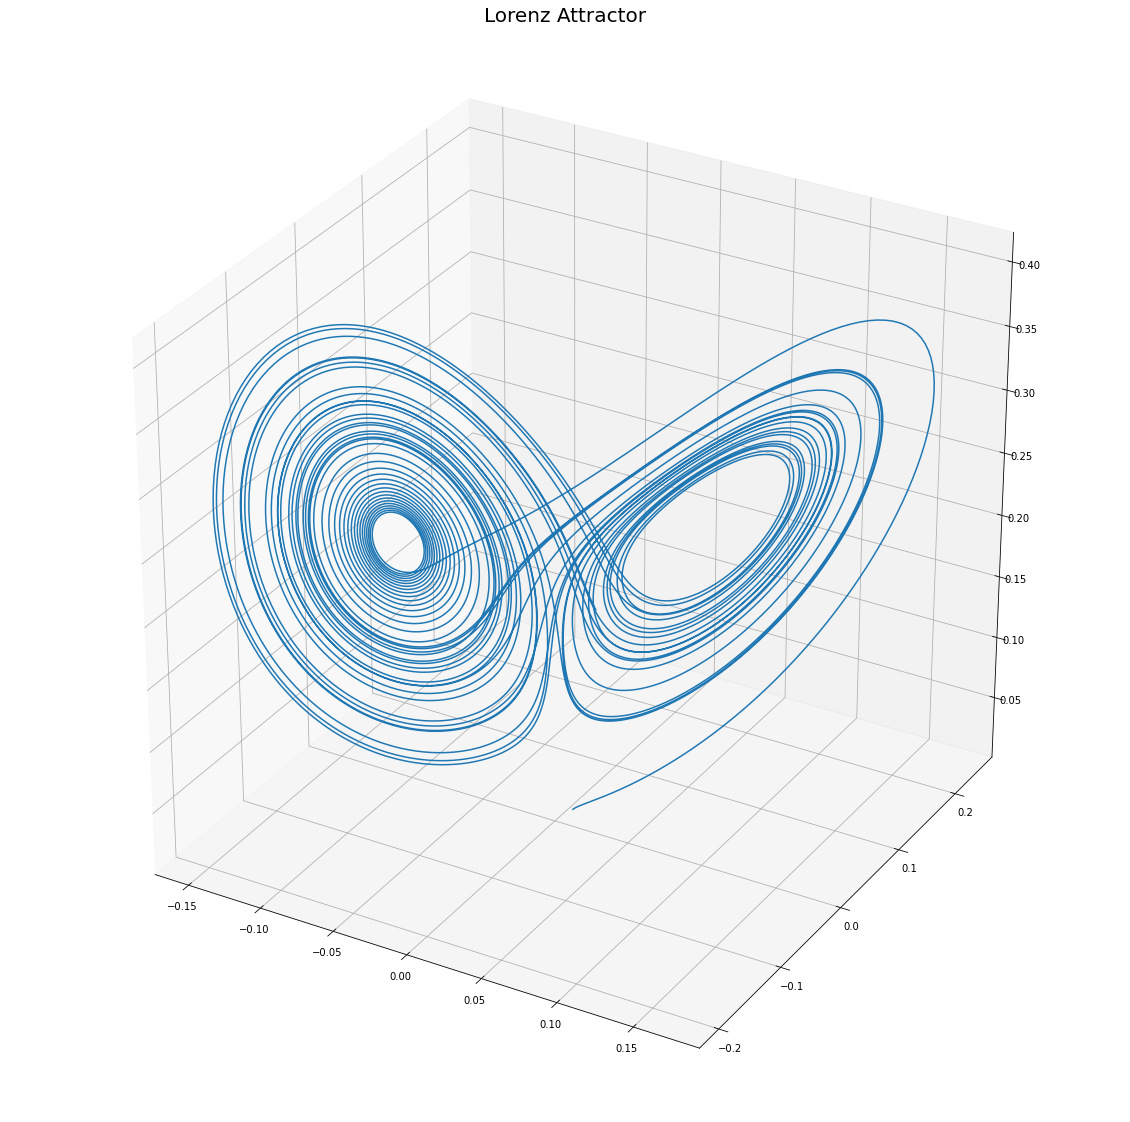

In [ ]:
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Formatting Definitions
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
    
def bold(str):
    return color.BOLD + str + color.END

# initalize plot window size
width1 = 20
height1 = 20
width2 = 7
height2 = 7
dims = (width1, height1)
small_dims = (width2, height2)

# Lorenz Attractor Parameters
rho = 28.0
sigma = 10
beta = 8.0 / 3.0

############################################
# f: defines Lorenz Equations
#
# @state: intial state
# @t: time window over which to solve ODEs
############################################
def f(state, t):  
    # Unpack the state vector
    x, y, z = state  

    # define the Lorenz Equations
    dx_dt = sigma * (y - x)
    dy_dt = x * (rho - z) - y
    dz_dt = x * y - beta * z
    
    # return derivatives
    return dx_dt, dy_dt, dz_dt

# initial state
state0 = [1.0001, 1.0, 1.0]

# timeframe to solve over
t = np.arange(0.0, 40.0, 0.003)

# solve ODEs
states = odeint(f, state0, t)
N = len(states)
states = pow(N,-(1/2))*states

# plot
fig = plt.figure(figsize=dims)
ax = fig.gca(projection='3d')
ax.plot(states[:, 0], states[:, 1], states[:, 2])
plt.draw()
plt.title('Lorenz Attractor',fontsize=20)
plt.show()


Observe the nonlinear, chaotic behavior of the system. Solutions oscillate between the "wings" at unpredictable intervals dependent on the initial conditions and provided parameters of the system.

### Singular Spectrum Analysis


#### Time Delay Embedding

From [<sup>1</sup>](#fn1):
> In a nonlinearly coupled system the time series data of one of its variables could contain the essential details of the evolution of all the variables of the system. This is true even though the number of other variables of the system and their time behavior are not directly known, and this recognition has led to the embedding technique of phase space reconstruction ...

The first step in constructing such an embedding is to construct an $m$-component delay vector $X_i$ at time $t = t_i$ as:
\begin{align}
\\
X_i = [x_1(t_i), x_2(t_i), ... , x_m(t_i)]
\\
\end{align}

where $x_k(t_i) = x(t_i + (k - 1) \tau)$ and $\tau$ is is a time-delay large enough to overcome autocorrelation, and small enough to still observe the physical processes of interest. From these $m$-dimensional delay vectors, we can construct a trajectory matrix as:

\begin{align}
\\
X = N^{-\frac{1}{2}}\begin{bmatrix}
x_1(t_1) & x_2(t_1) & ... & x_m(t_1)\\
x_1(t_2) & x_2(t_2) & ... & x_m(t_2) \\
. \\
. \\
x_1(t_N) & x_2(t_N) & ... & x_m(t_N)
\end{bmatrix}
\\
\end{align}

In the case of the Lorenz Attractor data, we then get:


 Trajectory Matrix 



0         1         2         3         4
0      7.508262e-05  0.000079  0.000090  0.000109  0.000135
1      7.516931e-05  0.000080  0.000093  0.000112  0.000139
2      7.542628e-05  0.000082  0.000095  0.000115  0.000144
3      7.584862e-05  0.000083  0.000098  0.000119  0.000148
4      7.643196e-05  0.000085  0.000100  0.000123  0.000153
...             ...       ...       ...       ...       ...
13301 -5.800767e-06  0.000036  0.000070  0.000099  0.000124
13302  8.034711e-07  0.000042  0.000075  0.000102  0.000127
13303  7.193539e-06  0.000047  0.000079  0.000106  0.000130
13304  1.337806e-05  0.000052  0.000083  0.000110  0.000134
13305  1.936553e-05  0.000056  0.000087  0.000113  0.000137

[13306 rows x 5 columns]

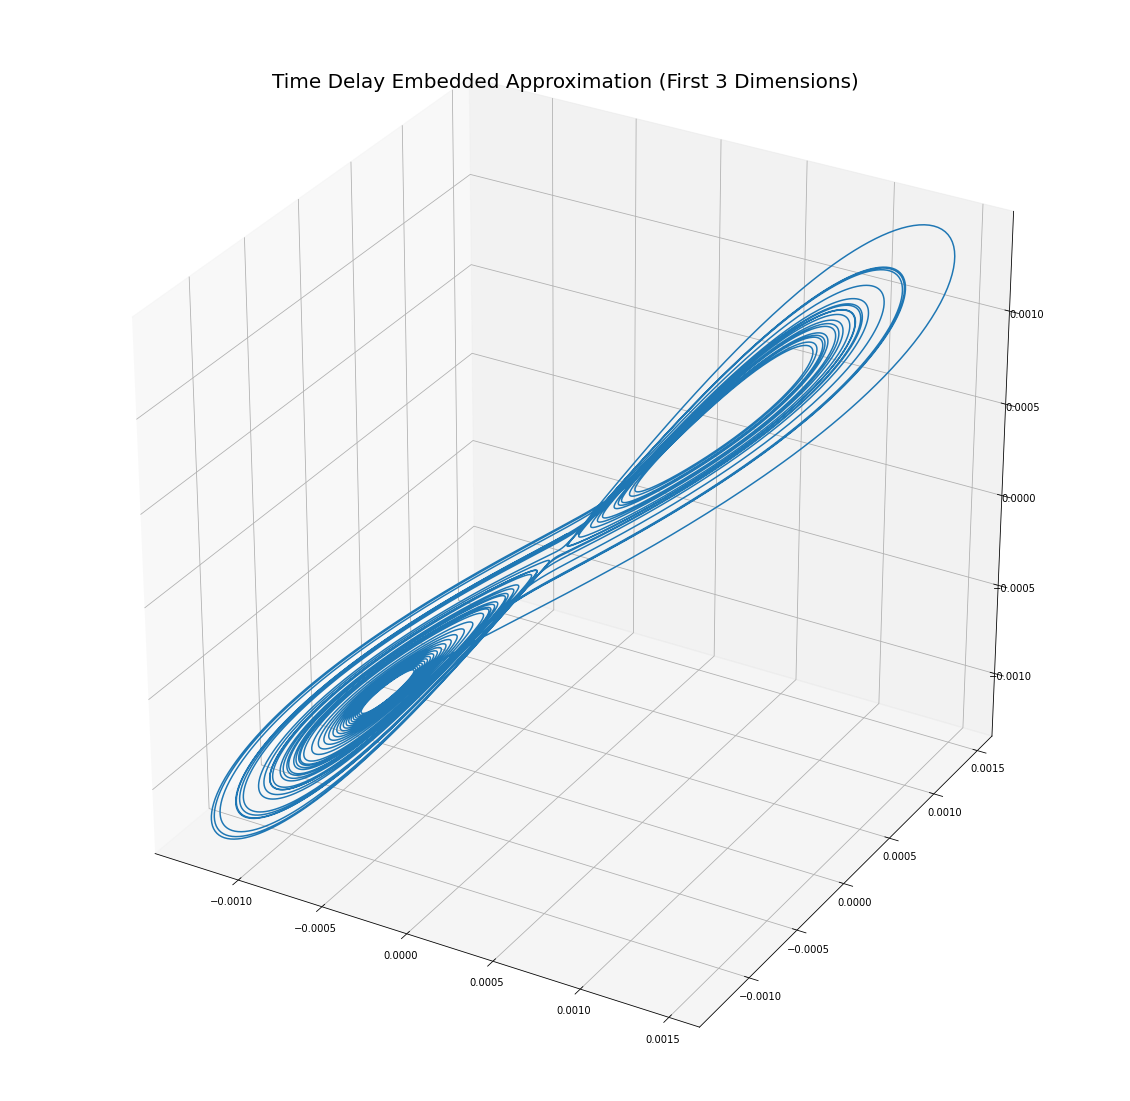

In [ ]:
import pandas as pd
import math
from IPython.display import display

#################################################
# time_delay_embed: return time delay embedding 
# 
# @A: N x 1 data to be embedded
# @m: dimension of state space
# @tau: time delay
#
# Returns:
# N x m matrix time delay embedding of A
##################################################
def time_delay_embed(A, m, tau):
     return A[(np.arange(m)*(tau))+ np.arange(np.max(A.shape[0] - (m-1)*(tau), 0)).reshape(-1,1)]

# embedding parameters
m = 5
tau = 7

# get first dimension of the Lorenz Attractor Data
x = np.array([x[0] for x in states])

# get time-delay embedding of first dimension of data
xd = time_delay_embed(x,m,tau)
N = len(xd)

# Look at Trajectory Matrix
print(bold('\n Trajectory Matrix \n'))
tm = xd*(math.pow(N,-1/2))
display(pd.DataFrame(tm))

# Plot the first 3 dimensions of the Trajectory Matrix
fig = plt.figure(figsize=dims)
ax = fig.gca(projection='3d')
ax.plot(tm[:, 0], tm[:, 1], tm[:, 2])
plt.title('Time Delay Embedded Approximation (First 3 Dimensions)',fontsize=20)
plt.draw()
plt.show()

Observe here that we are able to reconstruct the dynamics of the original system simply from creating a trajectory matrix from time-delay embedding a single dimension of the original data. We can see clearly the chaotic behavior, and unpredictable oscillations between the "wings" of the attractor.

#### Principal Component Analysis
We can perform an eigenvalue analysis of the trajectory matrix to determine the dimensions of greatest variance, contributing the most information to the system. With our prior knowledge that the original data is 3-dimensional, we should expect this analysis to expose 3 principal components. In the ideal case, the principal components would contribute 100% of the variance, but given the noise introduced by our approximation of the system, all eigenvalues will be greater than 0. A full eigenvalue analysis will show that we can extract the relevent eigenvalues/eigenvectors from the $m \times m$ covariance matrix $Z = X^TX$, which is a major advantage, as $m$ is typically in the range ~5-25 and $N$ can easily be on the order of tens of thousands or more. 

In [ ]:
fig = plt.figure(figsize=(15,10))
tau = 7

# Look at eigenvalues for embeddings from 5 - 25
# at intervals of 5
for i in reversed(range(5,31,5)):
    index = [x for x in reversed(range(1,i+1))]

    # time-delay embed into i dimensions
    xd = time_delay_embed(x,i,tau)
    N = len(xd)
    
    # get trajectory matrix
    tm = xd*(math.pow(N,-1/2))
    
    # Get X^T * X
    xtx = np.matmul(tm.transpose(),tm)
    
    # Get the Eigenvalues and Eigenvectors
    eigenvalues,eigenvectors = np.linalg.eig(xtx)
    
    # normalize the eigenvalues between 0 and 1
    norm_eigenvalues = [x/max(eigenvalues) for x in eigenvalues]
    
    # plot
    plt.plot(index,norm_eigenvalues, 'ro-')

# plot
plt.title('Eigenvalues for Increasing m',fontsize=20)
plt.xlabel('m',fontsize=14)
plt.ylabel('Eigenvalues',fontsize=14)
plt.show()


As we expected, we see that the majority of the variance is explained by the first dimension, and the next 2 dimensions explain the majority of what remains, for the most part regardless of what we select for $m$. The corresponding eigenvectors give an orthogonal principal directions in the embedding space along which the dominant dynamical features are expressed. We can then project the time series data along this orthonormal basis to yield the principal coordinates $y_i$ of the system. These variables obtained from the Principal Component Analysis are relatively free from noise, and are better suited to represent the phase space. 

<Figure size 2160x1440 with 0 Axes>

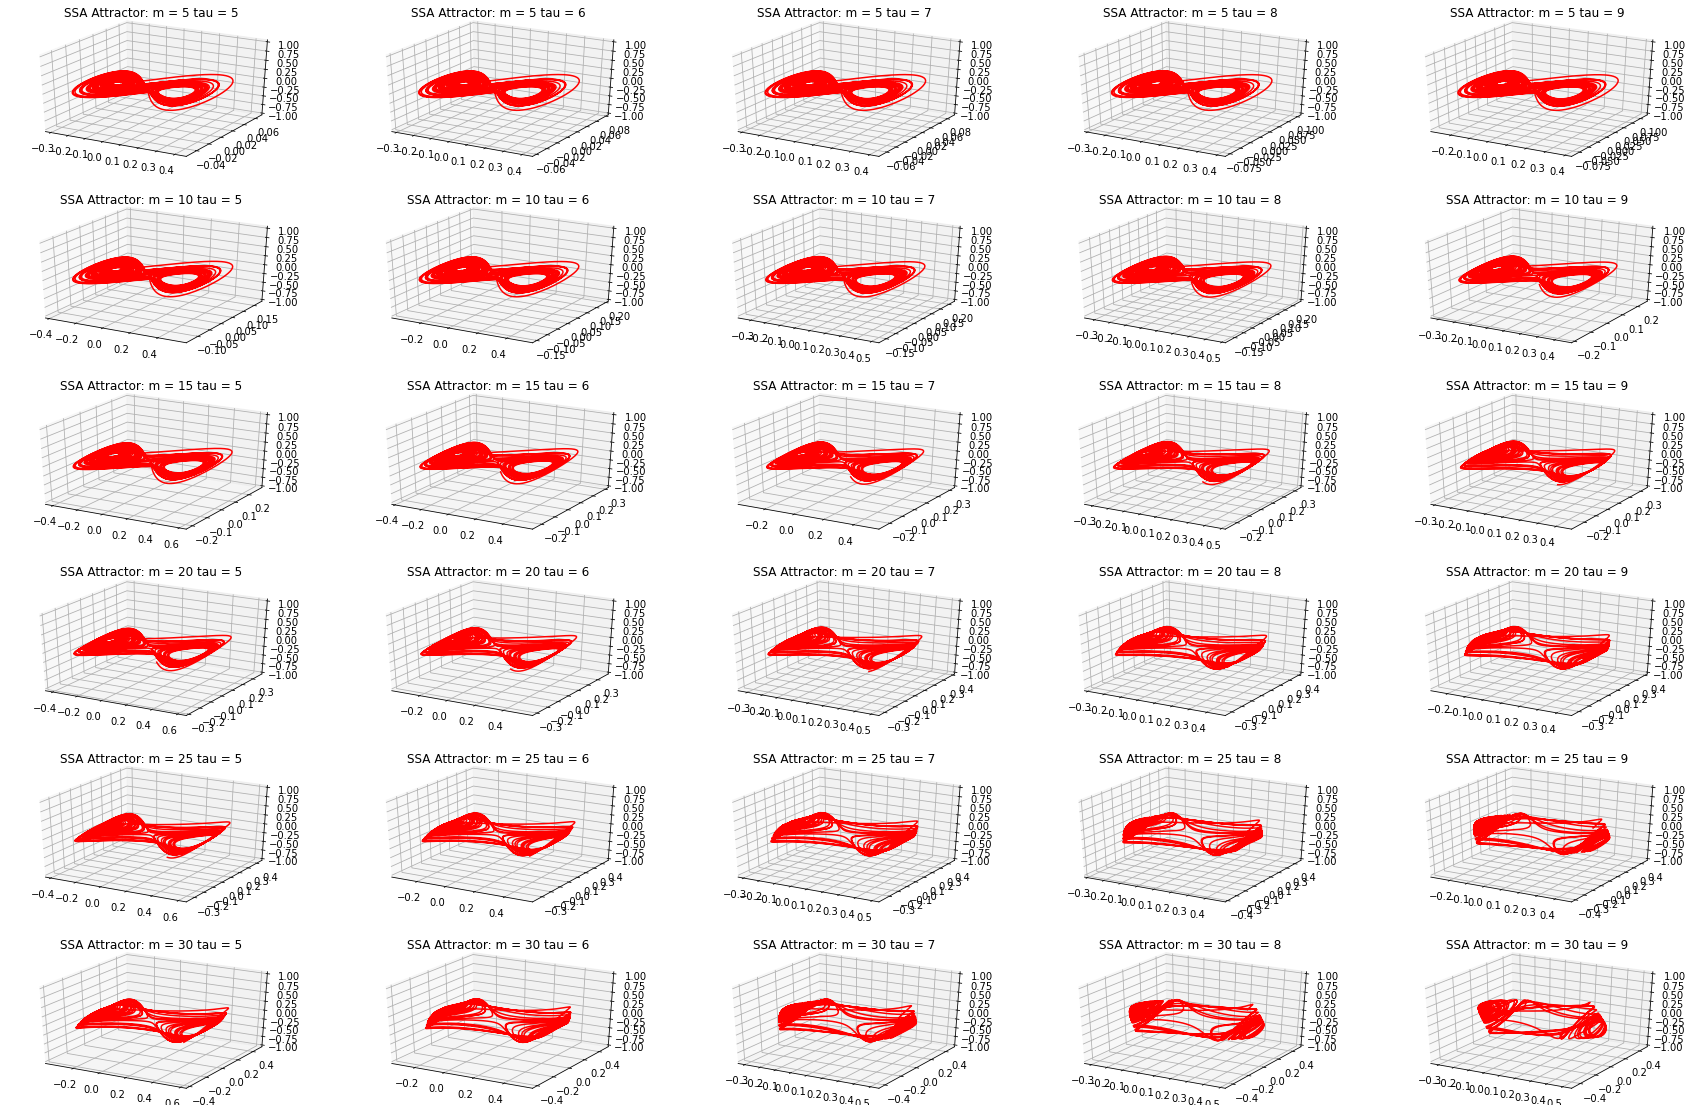

(-1.01, 1.01)

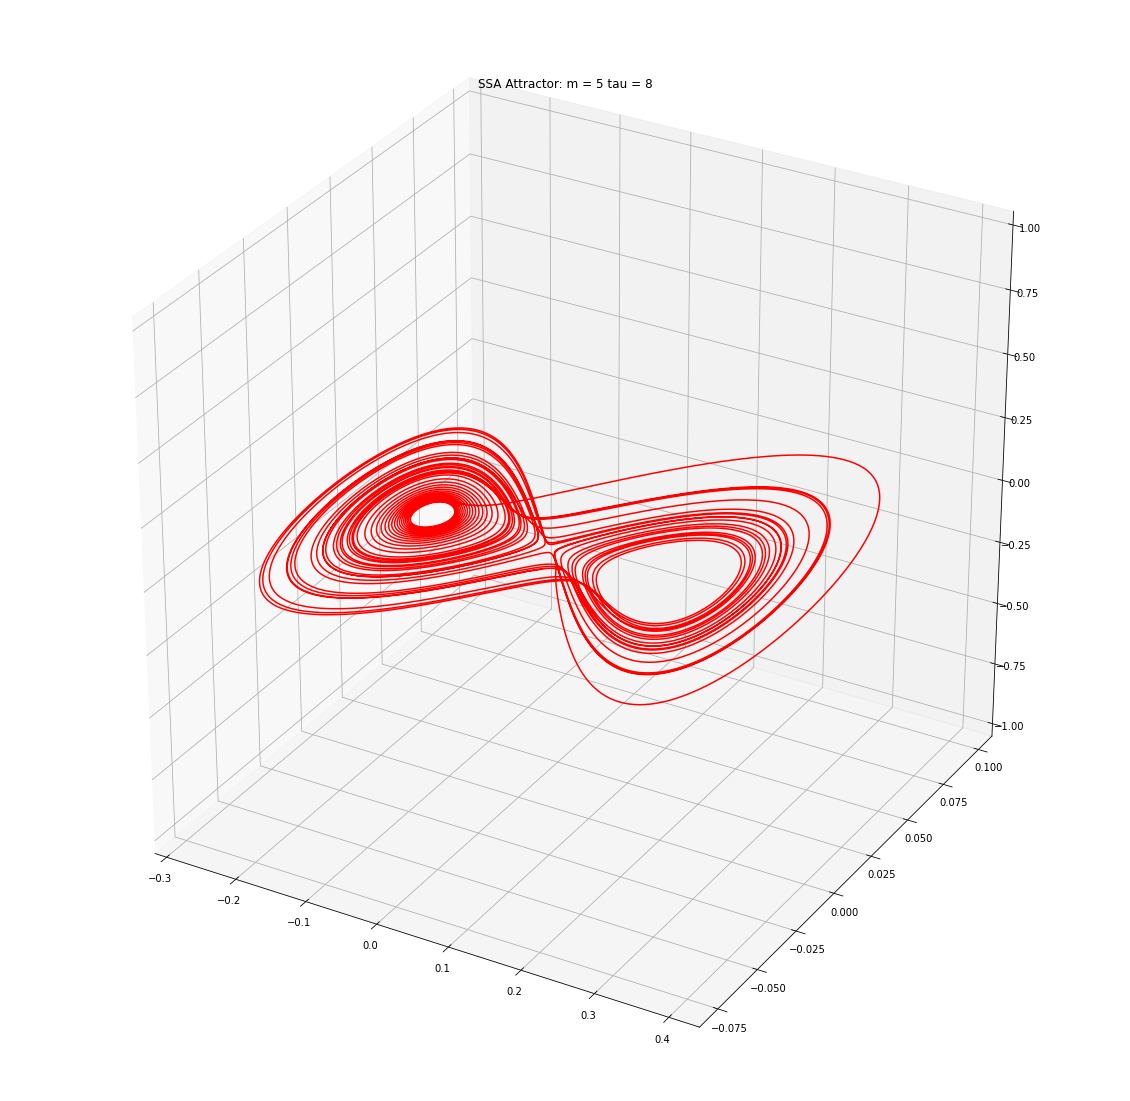

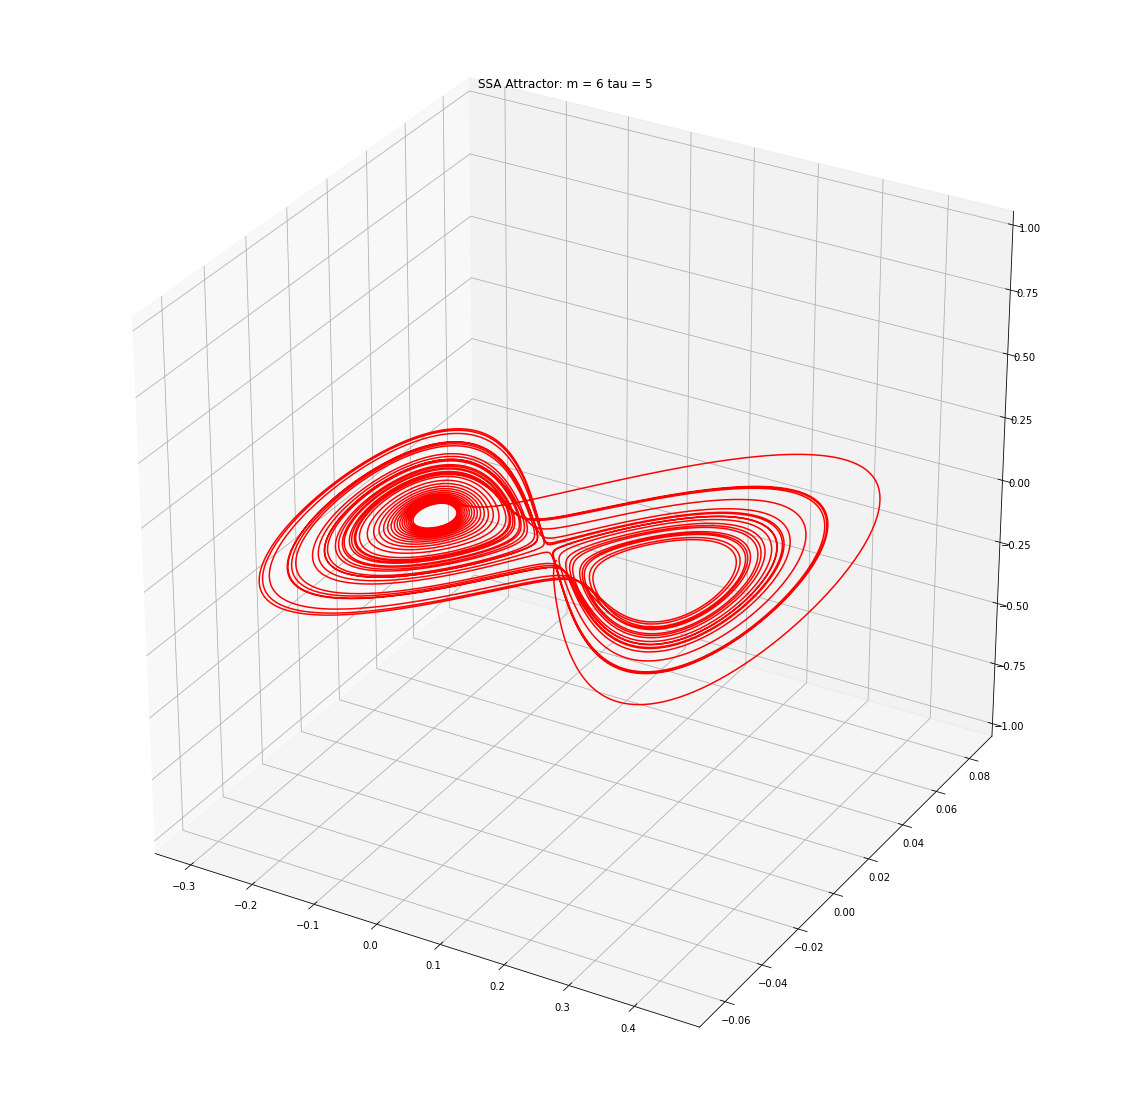

In [ ]:
from sklearn.decomposition import PCA

fig = plt.figure(figsize=(30,20))
i = 1
tau = 9

'''for m in range(5,6,5):

  
  # get time-delay embedding of first dimension of data
  xd = time_delay_embed(x,m,tau)
  N = len(xd)

  # Look at Trajectory Matrix
  #print(bold('\n Trajectory Matrix \n'))
  tm = xd*(math.pow(N,-1/2))

  # get the covariance matrix X^T * X
  xtx = np.matmul(tm.transpose(),tm)

  # get eigenvalues/eigenvectors
  eigenvalues,eigenvectors = np.linalg.eig(xtx)

  #print(bold('\n Trimmed Normalized Eigenvalues (First 3) \n'))
  #norm_eigenvalues = [x/max(eigenvalues) for x in eigenvalues]
  #print(norm_eigenvalues[:3])

  # create a projection matrix from these eigenvectors
  proj_mat = np.hstack((eigenvectors[0].reshape(m,1),eigenvectors[1].reshape(m,1),eigenvectors[2].reshape(m,1)))
  #print(bold('\n Eigenvectors (Projection Matrix) \n'))
  #display(pd.DataFrame(proj_mat))

  # project the delay embedded time series data onto the principal components
  new_data = np.matmul(tm,proj_mat)
  #print(bold('\n Embedded Time Series Data Projected onto Principal Components \n'))
  #display(pd.DataFrame(new_data))

  #ax = fig.add_subplot(2, 3, i, projection='3d')
  fig = plt.figure(figsize=dims)
  ax = fig.gca(projection='3d')
  ax.plot(new_data[:, 0], new_data[:, 1], new_data[:, 2], 'r')
  ax.set_title('SSA Attractor: m = ' + str(m))
  ax.set_zlim(-1.01, 1.01)

  # increment plot index
  i += 1

plt.show()'''


i = 1
fig = plt.figure(figsize=(30,20))
for m in range(5,31,5):
  for tau in range(5,10):
    xd = time_delay_embed(x,m,tau)
    pca = PCA(n_components=3)
    new_data = pca.fit_transform(xd)
    
    ax = fig.add_subplot(6, 5, i, projection='3d')
    ax = fig.gca(projection='3d')
    ax.plot(new_data[:, 0], new_data[:, 1], new_data[:, 2], 'r')
    ax.set_title('SSA Attractor: m = ' + str(m) + ' tau = ' + str(tau))
    ax.set_zlim(-1.01, 1.01)
    i += 1

plt.show()




m = 5
tau = 8
xd = time_delay_embed(x,m,tau)
pca = PCA(n_components=3)
new_data = pca.fit_transform(xd)

fig = plt.figure(figsize=dims)
ax = fig.gca(projection='3d')
ax.plot(new_data[:, 0], new_data[:, 1], new_data[:, 2], 'r')
ax.set_title('SSA Attractor: m = ' + str(m) + ' tau = ' + str(tau))
ax.set_zlim(-1.01, 1.01)


m = 6
tau = 5
xd = time_delay_embed(x,m,tau)
pca = PCA(n_components=3)
new_data = pca.fit_transform(xd)

fig = plt.figure(figsize=dims)
ax = fig.gca(projection='3d')
ax.plot(new_data[:, 0], new_data[:, 1], new_data[:, 2], 'r')
ax.set_title('SSA Attractor: m = ' + str(m) + ' tau = ' + str(tau))
ax.set_zlim(-1.01, 1.01)

Notice again that we're able to observe the essential dynamics of the system. Looking at the Root Mean Squared Error between these two approximations, defined as:

\begin{align}
\\
\sqrt{\frac{1}{n}\sum^{n}_{i=0} (y_i - \hat{y_i})^2}
\\
\end{align}

we see that they actually perform almost identically. In this case, it is probably becuase the original data we're operating on comes from noiseless equations. Given noisy data from most other applications, we would expect the model coming from the projection onto the principal components to be much more accurate than the intermediate trajectory matrix.

In [ ]:
states = odeint(f, state0, t)
states_trimmed = states[:len(new_data)]
mse_pc = ((states_trimmed - new_data)**2).mean(axis=None)
print(bold('Root Mean Squared Error with Principal Components: '), math.sqrt(mse_pc))

tm = xd*(math.pow(N,-1/2))
tm_trimmed = tm[:len(states),:3]
mse_tm = ((states_trimmed - tm_trimmed)**2).mean(axis=None)
print(bold('Root Mean Squared Error with Trajectory Matrix: '), math.sqrt(mse_tm))

Root Mean Squared Error with Principal Components:  16.30510694659515
Root Mean Squared Error with Trajectory Matrix:  16.329123001386147


## Recurrent Neural Network
Here we will begin to look at the Recurrent Neural Network architecture used to continue our analysis.

### RNN Definition
Recurrent Neural Networks (RNNs) are a form of neural network which are able to exhibit temporal dynamic behavior. They accomplish this by forming connections between nodes which take the form of a directed graph along a temporal sequence. In the general case, this is implemented by recursively feeding back in the output after each training sample (at time $t$) back in as an additional input along with the next sample (at time $t + 1$). The following diagram shows the recursive nature of the model, as well as an "unrolled" version of the first few training examples. 
<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/Recurrent_neural_network_unfold.svg/1920px-Recurrent_neural_network_unfold.svg.png" alt="rnn"/>
</center>
[https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/Recurrent_neural_network_unfold.svg/1920px-Recurrent_neural_network_unfold.svg.png]

The reason this is a particularly good network architecture to model complex time-series data is because within complex systems, the state at time $t+1$ isn't just dependent on the state at time $t$, but on the trajectory of the system leading up to time $t + 1$. In feeding in the output of the previous time step in the subsequent step, we account for the trajectory a system went through when making a prediction for each state in the sequence. 

### Long Short Term Memory (LSTM) network
The specific RNN architecture we will be employing is called a Long Short Term Memory (LSTM) Network. LSTMs are a typical recurrent neural network, with the addition of a "cell memory unit" - a vector added to nodes which enable them to "forget" unimportant parts of previously stored memory, and also store new information. One of the core drawbacks to standard RNNs is a phenomenon called the "vanishing gradient". Neural nets typically learn by updating weights proportially to partial derivatives of their loss function with respect to the current weight through backpropagation. In particular cases, these gradients can become vanishingly small, causing the network to essentially stop learning - a drawback RNNs are particularly susceptible to. The cell memory unit allows RNNs to overcome this phenomenon and learn relevent information over arbitrarily long gaps. The specific implementation of an LSTM network is beyond the scope of this project, but further information can be found <a href="https://www.mitpressjournals.org/doi/abs/10.1162/neco.1997.9.8.1735"> here </a>

Here we'll train the LSTM network on the projected data. We'll use Mean Squared Error as the loss function for the network and Adaptive Moment Estimation (ADAM) for optimization. We'll train the network for 100 epochs, and use 25 hidden neurons in the LSTM layer, and 9 neurons in the second hidden layer - both layers utilizing the $tanh$ activation function. Both the input and output are 3x1 vectors (x,y,z). We'll attempt to predict 10 time steps into the future, and so we'll create labels our labels as: $y_t = x_{t+30}$. We get $t+30$ for the label because we recall the projected data has undergone delay embedding with $\tau = 10$, giving deley vectors as: $x_i = [x_i(t_0), x_i(t_{10}), x_i(t_{20})]$, so to avoid leaking information about the future into the training data, we have to adjust our label to predict from the furthest forward timestep, which is $x_{t+20}$.


######################################################################
########################  Training on n =  1 #########################
######################################################################

Epoch 1/100
63/63 [==============================] - 2s 9ms/step - loss: 0.1408 - val_loss: 0.0633
Epoch 2/100
63/63 [==============================] - 0s 3ms/step - loss: 0.0395 - val_loss: 0.0313
Epoch 3/100
63/63 [==============================] - 0s 3ms/step - loss: 0.0231 - val_loss: 0.0270
Epoch 4/100
63/63 [==============================] - 0s 3ms/step - loss: 0.0194 - val_loss: 0.0229
Epoch 5/100
63/63 [==============================] - 0s 3ms/step - loss: 0.0157 - val_loss: 0.0193
Epoch 6/100
63/63 [==============================] - 0s 3ms/step - loss: 0.0127 - val_loss: 0.0169
Epoch 7/100
63/63 [==============================] - 0s 3ms/step - loss: 0.0109 - val_loss: 0.0156
Epoch 8/100
63/63 [==============================] - 0s 3ms/step - loss: 0.0100 - val_loss: 

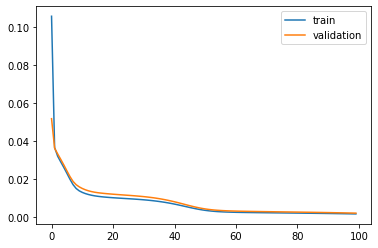

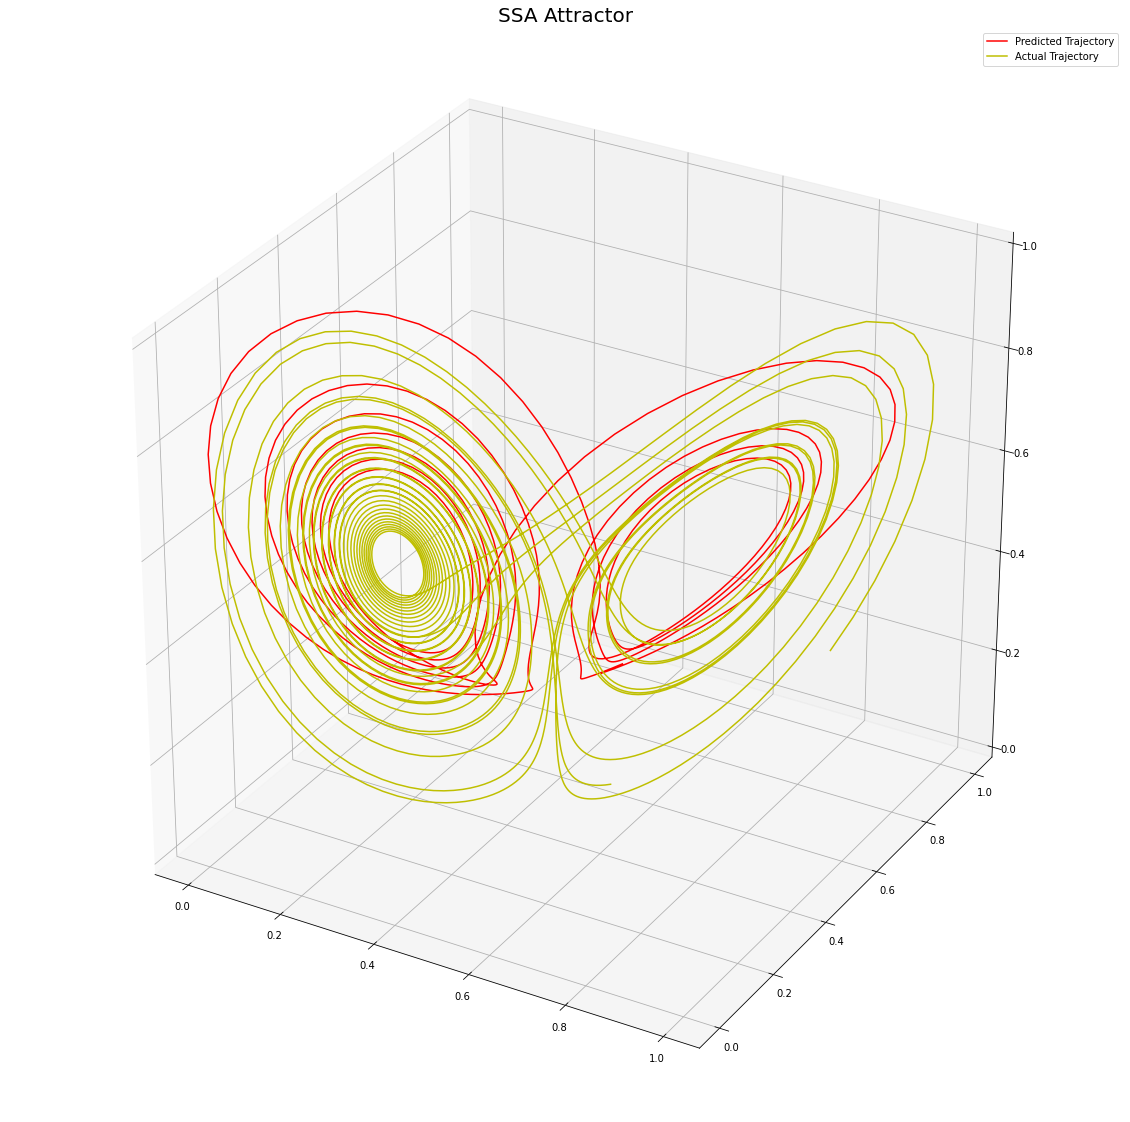


######################################################################
########################  Training on n =  6 #########################
######################################################################

Epoch 1/100
63/63 [==============================] - 2s 9ms/step - loss: 0.1238 - val_loss: 0.0453
Epoch 2/100
63/63 [==============================] - 0s 3ms/step - loss: 0.0290 - val_loss: 0.0345
Epoch 3/100
63/63 [==============================] - 0s 3ms/step - loss: 0.0252 - val_loss: 0.0315
Epoch 4/100
63/63 [==============================] - 0s 3ms/step - loss: 0.0228 - val_loss: 0.0286
Epoch 5/100
63/63 [==============================] - 0s 4ms/step - loss: 0.0203 - val_loss: 0.0257
Epoch 6/100
63/63 [==============================] - 0s 3ms/step - loss: 0.0178 - val_loss: 0.0229
Epoch 7/100
63/63 [==============================] - 0s 3ms/step - loss: 0.0155 - val_loss: 0.0205
Epoch 8/100
63/63 [==============================] - 0s 4ms/step - loss: 0.0135 - val_loss: 

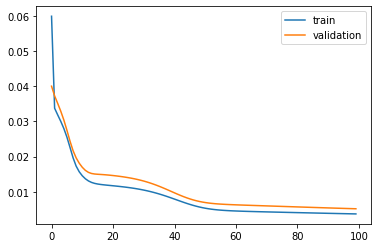

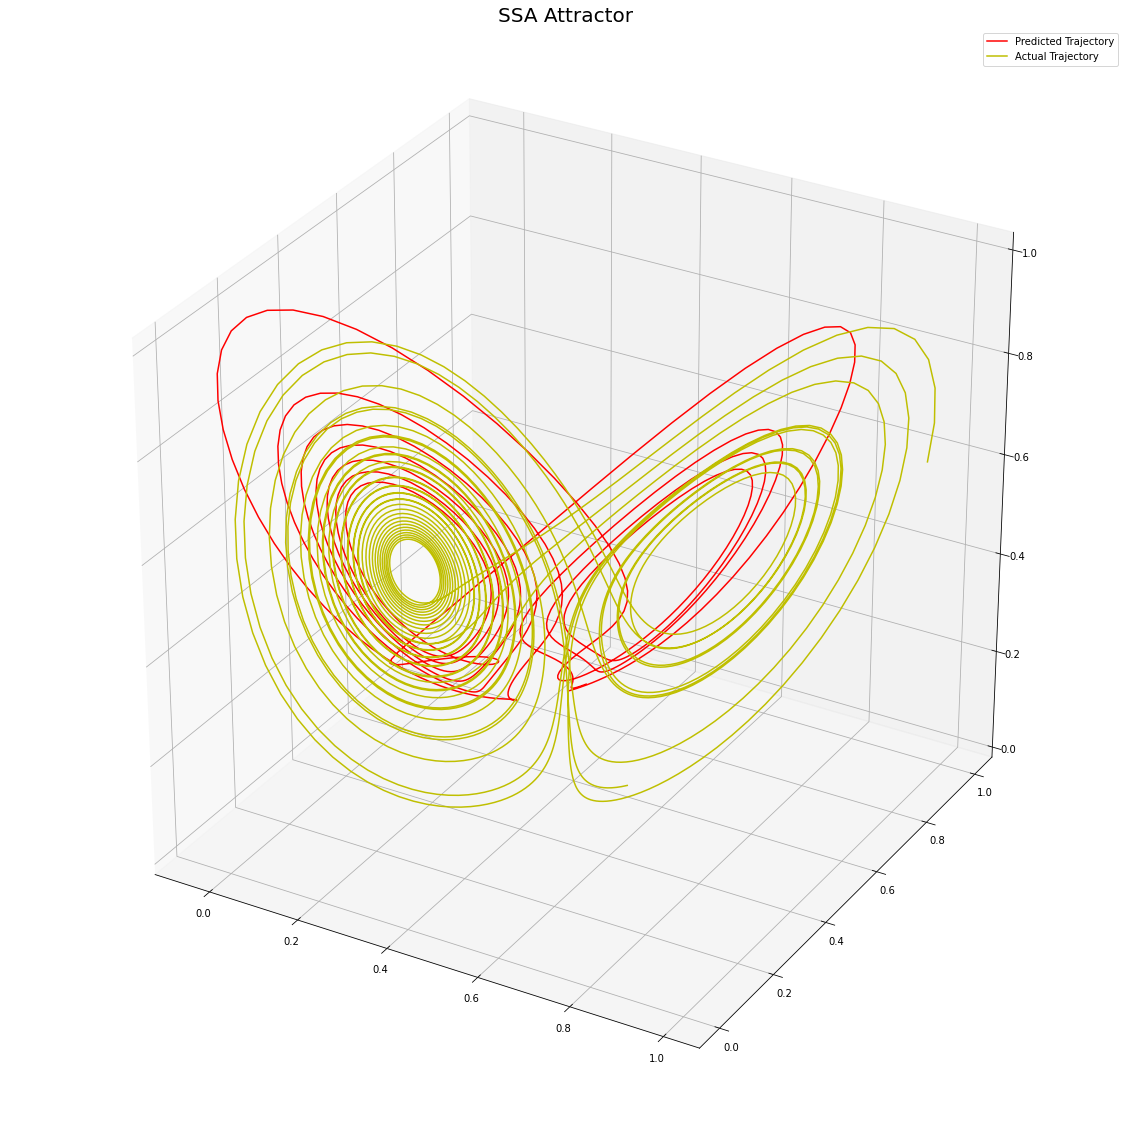


######################################################################
########################  Training on n =  11 #########################
######################################################################

Epoch 1/100
63/63 [==============================] - 2s 10ms/step - loss: 0.1221 - val_loss: 0.0462
Epoch 2/100
63/63 [==============================] - 0s 4ms/step - loss: 0.0279 - val_loss: 0.0370
Epoch 3/100
63/63 [==============================] - 0s 4ms/step - loss: 0.0259 - val_loss: 0.0339
Epoch 4/100
63/63 [==============================] - 0s 4ms/step - loss: 0.0235 - val_loss: 0.0307
Epoch 5/100
63/63 [==============================] - 0s 4ms/step - loss: 0.0210 - val_loss: 0.0275
Epoch 6/100
63/63 [==============================] - 0s 4ms/step - loss: 0.0184 - val_loss: 0.0246
Epoch 7/100
63/63 [==============================] - 0s 4ms/step - loss: 0.0162 - val_loss: 0.0225
Epoch 8/100
63/63 [==============================] - 0s 4ms/step - loss: 0.0146 - val_loss

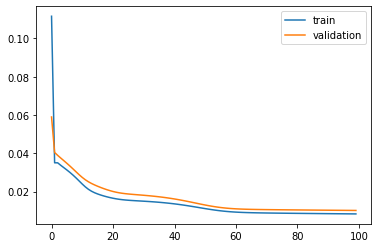

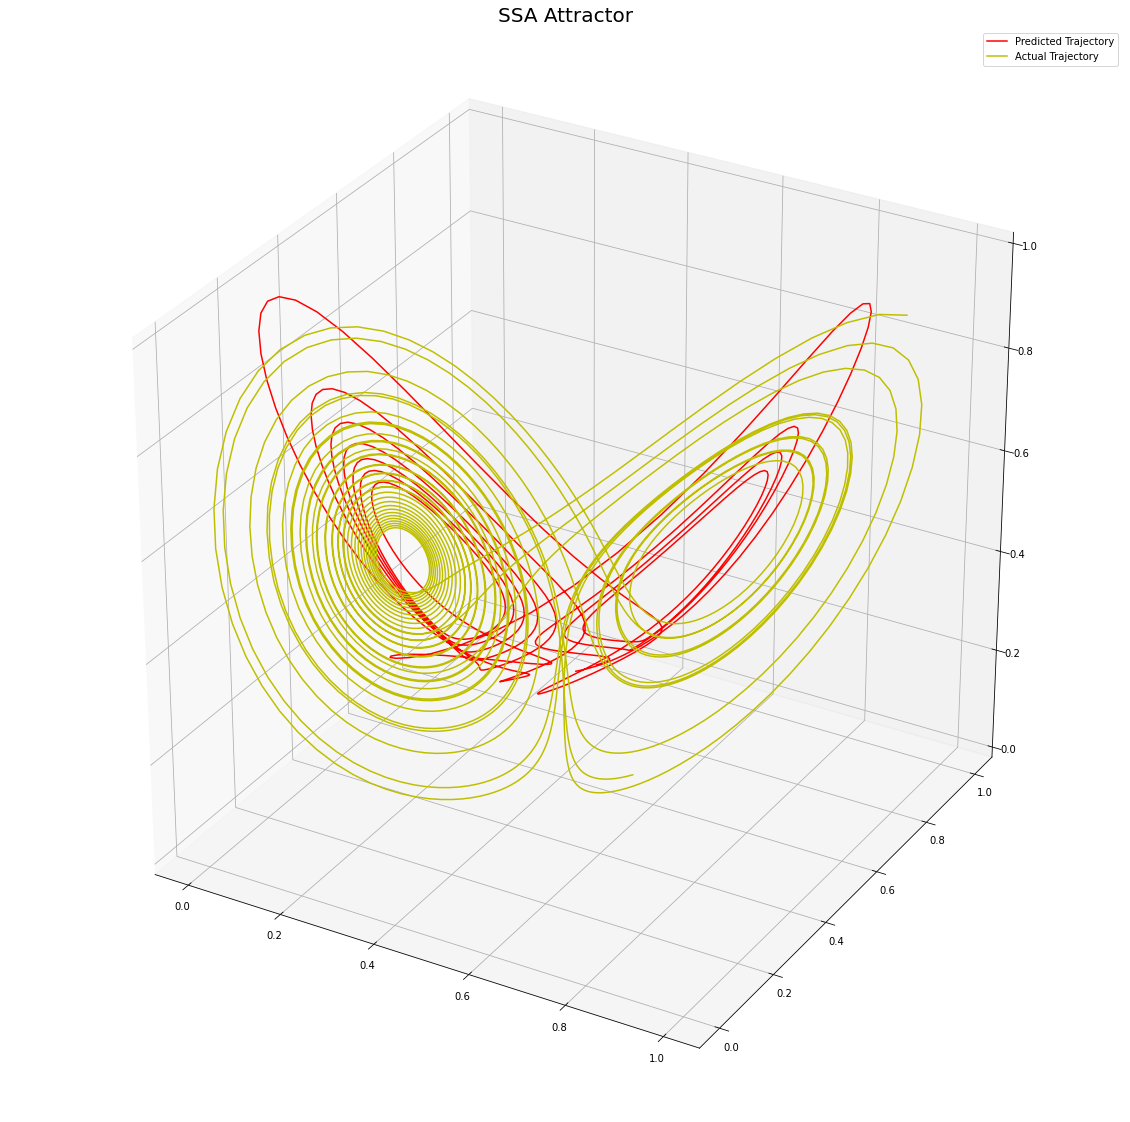


######################################################################
########################  Training on n =  16 #########################
######################################################################

Epoch 1/100
63/63 [==============================] - 2s 11ms/step - loss: 0.1097 - val_loss: 0.0485
Epoch 2/100
63/63 [==============================] - 0s 4ms/step - loss: 0.0227 - val_loss: 0.0362
Epoch 3/100
63/63 [==============================] - 0s 5ms/step - loss: 0.0233 - val_loss: 0.0345
Epoch 4/100
63/63 [==============================] - 0s 4ms/step - loss: 0.0220 - val_loss: 0.0329
Epoch 5/100
63/63 [==============================] - 0s 4ms/step - loss: 0.0208 - val_loss: 0.0315
Epoch 6/100
63/63 [==============================] - 0s 5ms/step - loss: 0.0197 - val_loss: 0.0303
Epoch 7/100
63/63 [==============================] - 0s 4ms/step - loss: 0.0188 - val_loss: 0.0292
Epoch 8/100
63/63 [==============================] - 0s 5ms/step - loss: 0.0180 - val_loss

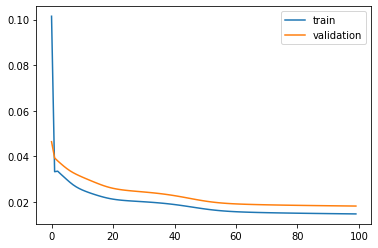

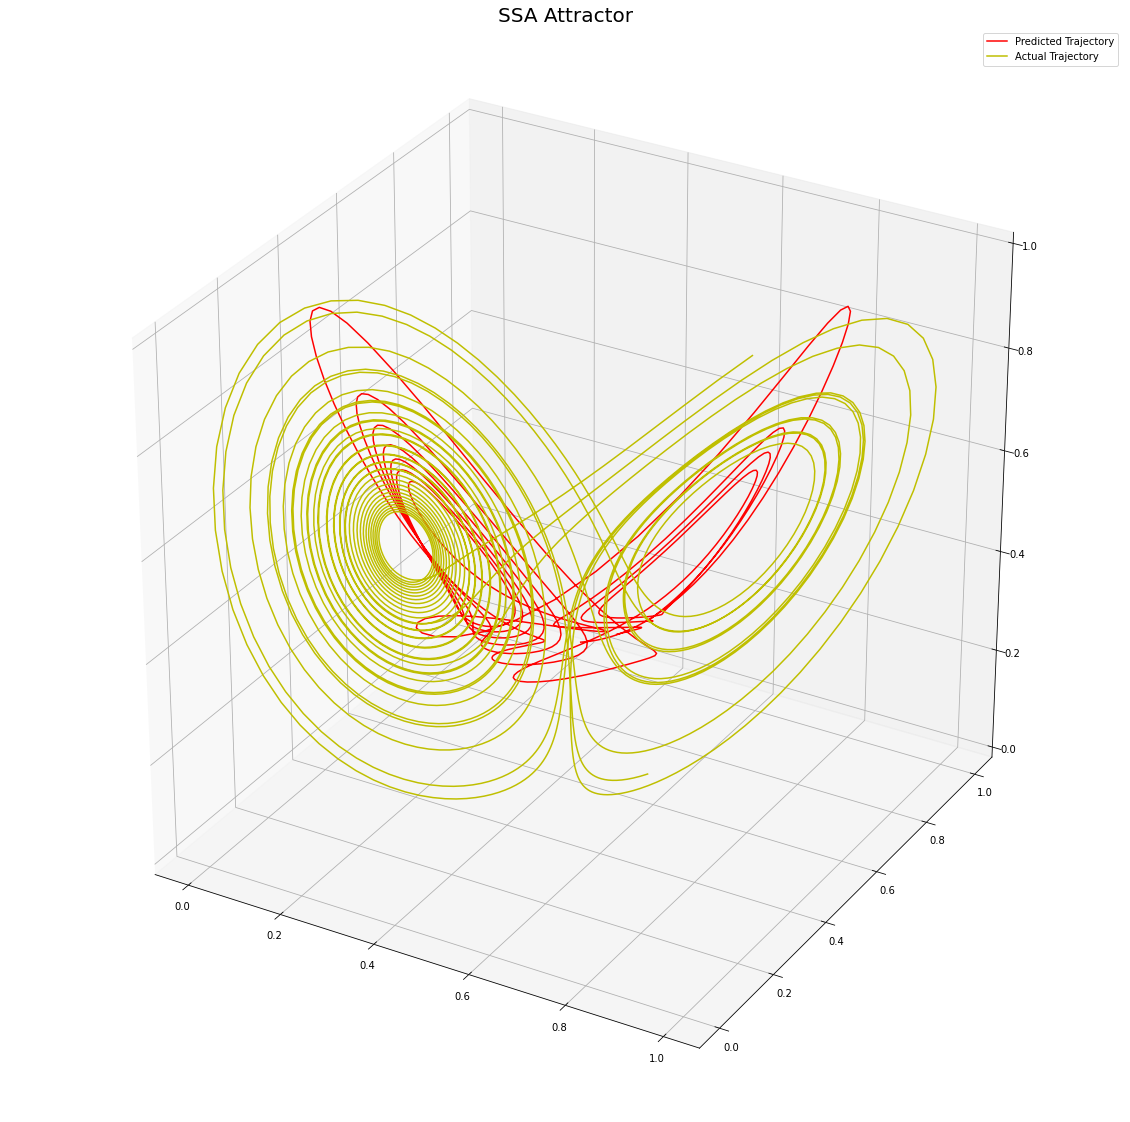


######################################################################
########################  Training on n =  21 #########################
######################################################################

Epoch 1/100
63/63 [==============================] - 2s 11ms/step - loss: 0.1201 - val_loss: 0.0474
Epoch 2/100
63/63 [==============================] - 0s 5ms/step - loss: 0.0269 - val_loss: 0.0439
Epoch 3/100
63/63 [==============================] - 0s 5ms/step - loss: 0.0265 - val_loss: 0.0423
Epoch 4/100
63/63 [==============================] - 0s 5ms/step - loss: 0.0254 - val_loss: 0.0407
Epoch 5/100
63/63 [==============================] - 0s 5ms/step - loss: 0.0244 - val_loss: 0.0393
Epoch 6/100
63/63 [==============================] - 0s 5ms/step - loss: 0.0235 - val_loss: 0.0378
Epoch 7/100
63/63 [==============================] - 0s 5ms/step - loss: 0.0225 - val_loss: 0.0364
Epoch 8/100
63/63 [==============================] - 0s 5ms/step - loss: 0.0216 - val_loss

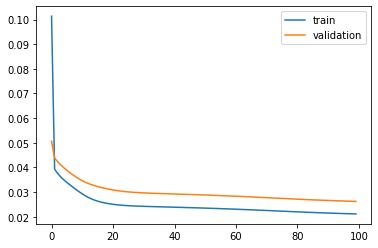

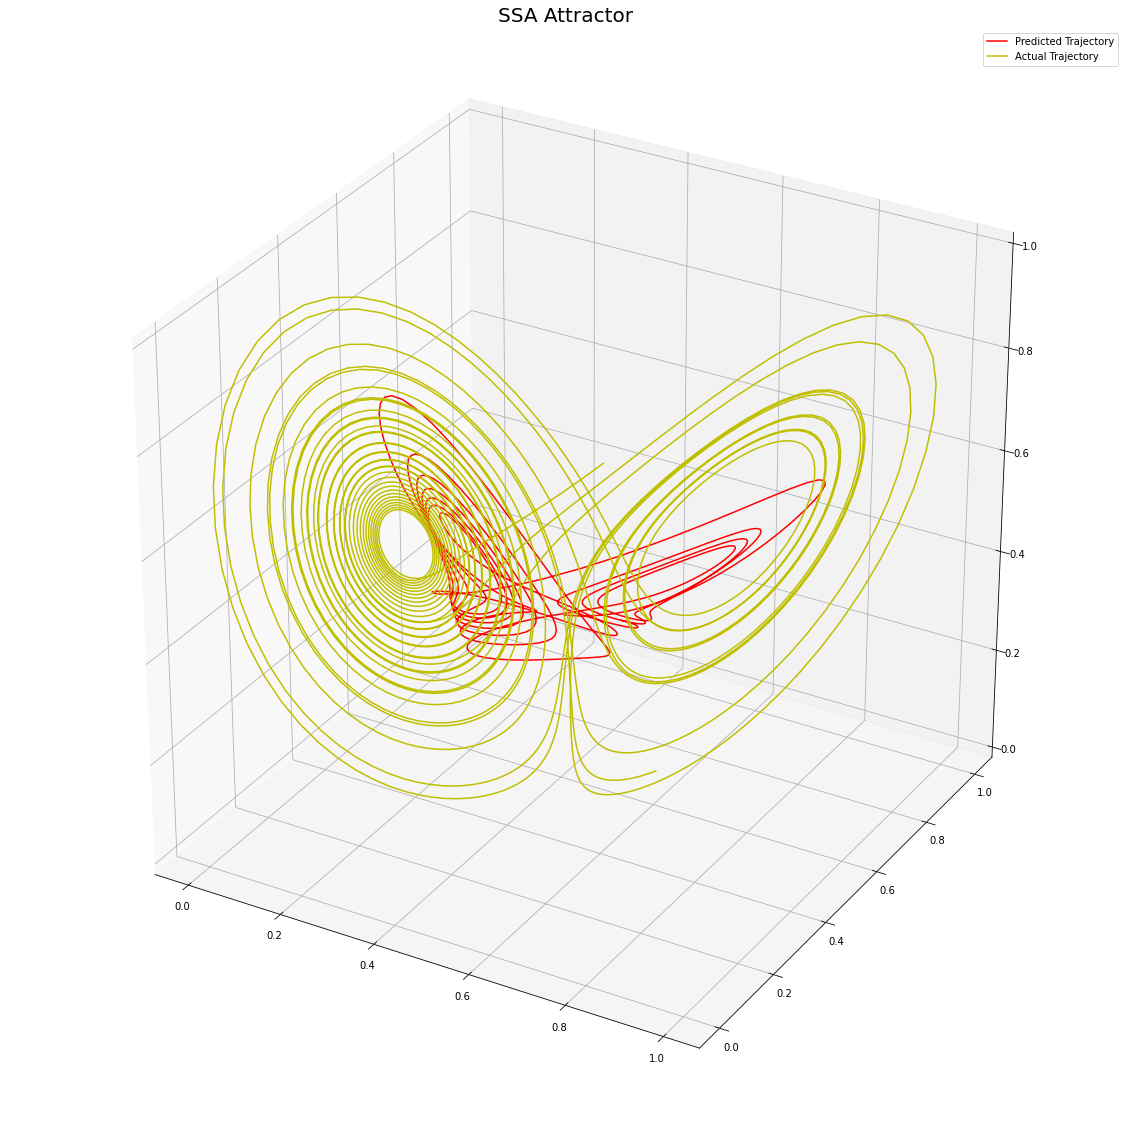


######################################################################
########################  Training on n =  26 #########################
######################################################################

Epoch 1/100
63/63 [==============================] - 3s 15ms/step - loss: 0.1167 - val_loss: 0.0548
Epoch 2/100
63/63 [==============================] - 0s 4ms/step - loss: 0.0228 - val_loss: 0.0401
Epoch 3/100
63/63 [==============================] - 0s 5ms/step - loss: 0.0252 - val_loss: 0.0390
Epoch 4/100
63/63 [==============================] - 0s 5ms/step - loss: 0.0241 - val_loss: 0.0382
Epoch 5/100
63/63 [==============================] - 0s 4ms/step - loss: 0.0233 - val_loss: 0.0374
Epoch 6/100
63/63 [==============================] - 0s 5ms/step - loss: 0.0226 - val_loss: 0.0368
Epoch 7/100
63/63 [==============================] - 0s 5ms/step - loss: 0.0220 - val_loss: 0.0362
Epoch 8/100
63/63 [==============================] - 0s 5ms/step - loss: 0.0214 - val_loss

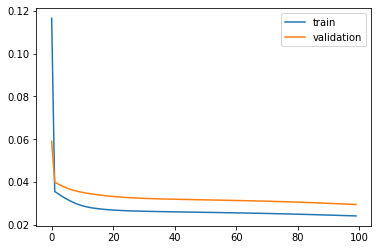

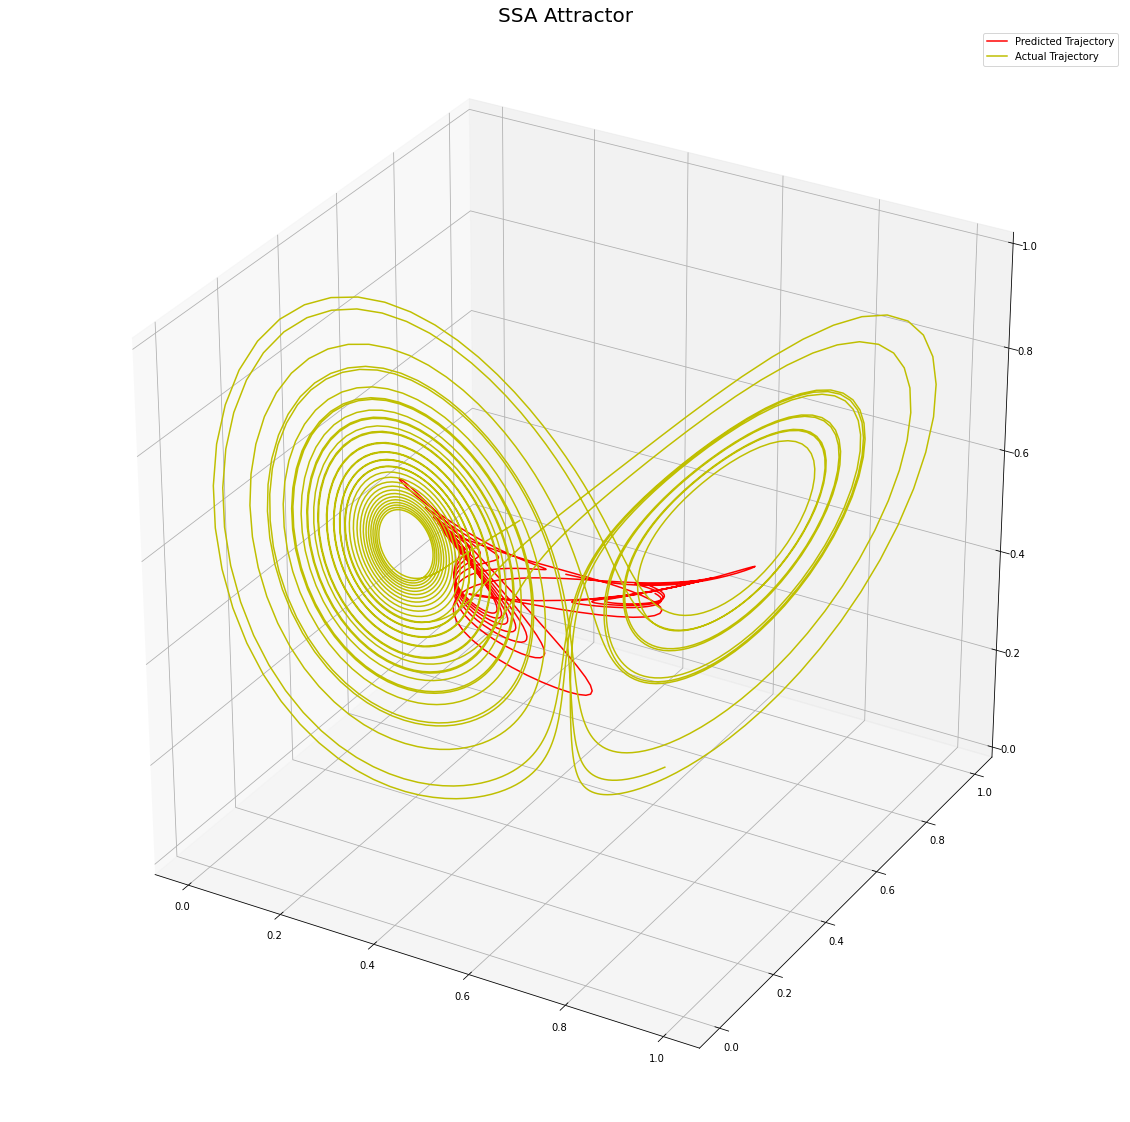

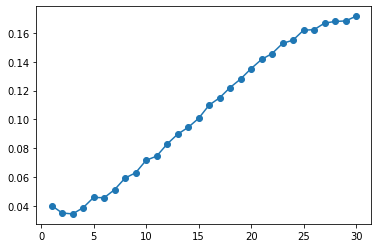

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error


'''xd = time_delay_embed(x,5,tau)
N = len(xd)
tm = xd*(math.pow(N,-1/2))
xtx = np.matmul(tm.transpose(),tm)
eigenvalues,eigenvectors = np.linalg.eig(xtx)
proj_mat = np.hstack((eigenvectors[0].reshape(m,1),eigenvectors[1].reshape(m,1),eigenvectors[2].reshape(m,1)))
new_data = np.matmul(tm,proj_mat)'''
rmses = []

for iter in range(1,31):
  print('\n######################################################################')
  print('########################  Training on n = ', iter,  '#########################')
  print('######################################################################\n')
  # Random Seed
  np.random.seed(7)

  # Initialize list for data
  data = []

  # How far we want to predict
  n = iter

  # Params
  train_split = 0.80
  input_vector_size = 3
  hidden_neurons = 25
  output_nodes = 3
  loss_function = 'mse'
  optimization_function = 'adam'
  training_verbosity = 1
  num_epochs = 100
  num_batch_size = 50
  iterative_predictions = False

  data = []
  for i in range(1, len(states) - n - 60):
      a = new_data[i]
      b = states[i+n+20]
      c = np.concatenate([a,b])
      data.append(c)
  data = np.array(data)


  # scale the data between 0 and 1 for training
  # keep the scaler so we can unencode at the end
  scaler = MinMaxScaler(feature_range=(0, 1))
  data = scaler.fit_transform(data)

  # split into test and training sets
  train_size = int(len(data) * train_split)
  test_size = len(data) - train_size
  train, test = data[0:train_size,:], data[train_size:len(data),:]
  train_X, train_y = train[:, :(input_vector_size * -1)], train[:,(input_vector_size * -1):]
  test_X, test_y = test[:, :(input_vector_size * -1)], test[:,(input_vector_size * -1):]


  # reshape input to be 3D [samples, timesteps, features]
  train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
  test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

  # Print data shape
  #print("Data Shape: \n")
  #print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
  #print("\n")

  ####################
  #
  # Construct the RNN
  #
  ####################

  # Sequential Model
  model = Sequential()

  # LSTM Model
  model.add(LSTM(hidden_neurons, input_shape=(train_X.shape[1], train_X.shape[2])))

  model.add(Dense(9, activation="tanh"))

  # Output Layer
  model.add(Dense(output_nodes))

  # Loss and Optimization functions
  model.compile(loss=loss_function, optimizer=optimization_function)

  ###########################
  #
  # End RNN Construction
  #
  ###########################

  ###############
  # Fit RNN
  ###############
  history = model.fit(train_X, train_y, epochs=num_epochs, batch_size=num_batch_size, validation_data=(test_X, test_y), verbose=training_verbosity, shuffle=False)

  ###############
  # Plot History
  ###############
  '''plt.plot(history.history['loss'], label='train')
  plt.plot(history.history['val_loss'], label='validation')
  plt.legend()
  plt.show()'''

  #########################
  # make a prediction
  #########################
  start_state = test_X[:1,:,:]

  if not iterative_predictions:
      yhat = model.predict(test_X)
  else:
      yhat = []
      step = 0

      # predict multiple steps
      for i in range(num_iterative_predictions):
          if step % 100 == 0:
              print('prediction ' + str(step) + ' of ' + str(num_iterative_predictions))
          next_state = model.predict(start_state)
          yhat.append(next_state[0].tolist())
          start_state = [next_state.tolist()]
          step += 1
      
      yhat = np.array(yhat)
      test_y = test_y[:num_iterative_predictions,:]
      

  test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

  # invert scaling for forecast
  inv_yhat = np.concatenate((yhat, test_X[:, 0:]), axis=1)
  inv_yhat = scaler.inverse_transform(inv_yhat)
  inv_yhat = inv_yhat[:,0]
  inv_yhat = yhat

  # invert scaling for actual
  inv_y = np.concatenate((test_y, test_X[:, 0:]), axis=1)
  inv_y = scaler.inverse_transform(inv_y)
  inv_y = inv_y[:,0]
  inv_y = test_y
  # calculate RMSE
  rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
  #print('Test RMSE: %.3f' % rmse)
  rmses.append(rmse)

  if iter%5 == 0:
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.legend()
    plt.show()
    #############################
    # Plot the results
    #############################
    fig = plt.figure(figsize=dims)
    ax = fig.gca(projection='3d')

    # Plot prediction
    ax.plot(inv_yhat[:, 0], inv_yhat[:, 1], inv_yhat[:, 2], 'r')
    #ax.plot(test_y[:, 0], test_y[:, 1], test_y[:, 2])
    ax.plot(train_y[:, 0], train_y[:, 1], train_y[:, 2], 'y')
    ax.legend(['Predicted Trajectory', 'Actual Trajectory', 'First 80% of timesteps'])
    plt.draw()
    plt.title('SSA Attractor',fontsize=20)
    plt.show()

plt.plot([x for x in range(1,len(rmses)+1)], rmses, 'o-')

We can see the model's predictions not only capture the essential dynamics of the system, but the shape of the predicted trajectory approaches the shape of the actual trajectory of the system.

*Note:*
It is important to recognize that these predictions are not iterative - that is, we are not feeding in the prediction at time $t$ in as the input to predict time $t+1$, but rather we are predicting from the points on the actual trajectory. If our aim was to utilize this network as a standalone model to predict the entire trajectory of the system, we would indeed want to optimize for iterative prediction - but within the greater context of this project, where we will be using this model as a component of our AI system searching for extreme events within the state space, it is sufficient to optimize for predicting from individual states in the original phase space.

For comparison, we can look at how this same network would perform when trained on the original Lorenz data:

[[4.96759936e-01 4.82032246e-01 4.93845886e-04 5.33931570e-01
  5.57354087e-01 0.00000000e+00]
 [4.97743777e-01 4.87309208e-01 2.42628748e-04 5.41570125e-01
  5.69763196e-01 2.17721356e-03]
 [4.99328273e-01 4.92790603e-01 7.29492577e-05 5.50176331e-01
  5.83574101e-01 5.02669405e-03]
 ...
 [4.72931448e-01 4.62766801e-01 2.49793441e-01 4.78606914e-01
  4.69678505e-01 1.82738975e-01]
 [4.73371876e-01 4.63147994e-01 2.42689565e-01 4.79452937e-01
  4.70865900e-01 1.77309788e-01]
 [4.73823394e-01 4.63586358e-01 2.35774365e-01 4.80380153e-01
  4.72180434e-01 1.72033295e-01]]


[[4.96759936e-01 4.82032246e-01 4.93845886e-04]
 [4.97743777e-01 4.87309208e-01 2.42628748e-04]
 [4.99328273e-01 4.92790603e-01 7.29492577e-05]
 ...
 [4.72931448e-01 4.62766801e-01 2.49793441e-01]
 [4.73371876e-01 4.63147994e-01 2.42689565e-01]
 [4.73823394e-01 4.63586358e-01 2.35774365e-01]]
Epoch 1/10
63/63 [==============================] - 2s 9ms/step - loss: 0.0993 - val_loss: 0.0258
Epoch 2/10
63/63 [============

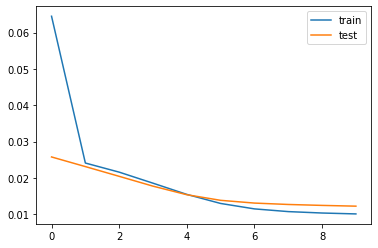

[[[0.47429252 0.46408487 0.22904316]]

 [[0.4747856  0.46464725 0.22249148]]

 [[0.47530889 0.46527805 0.21611501]]

 ...

 [[0.51840602 0.46003995 0.46812442]]

 [[0.51426171 0.46186511 0.45534065]]

 [[0.51074901 0.46370804 0.44291799]]]
Test RMSE: 2.538


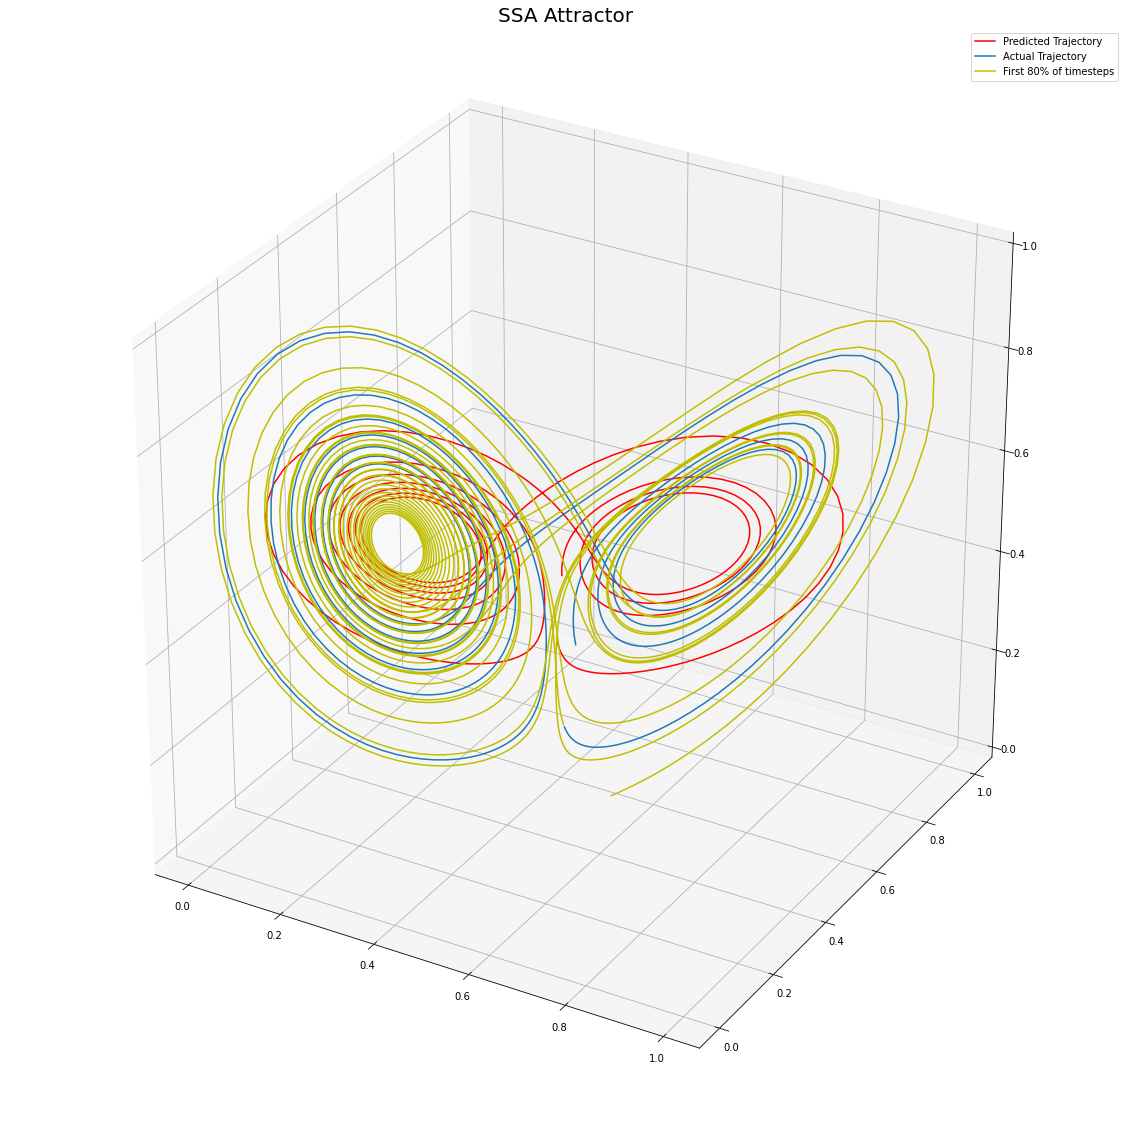

In [ ]:
data = []
for i in range(1, len(states) - n - 60):
    a = states[i]
    b = states[i+n]
    c = np.concatenate([a,b])
    data.append(c)
data = np.array(data)


# scale the data between 0 and 1 for training
# keep the scaler so we can unencode at the end
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

# split into test and training sets
train_size = int(len(data) * train_split)
test_size = len(data) - train_size
train, test = data[0:train_size,:], data[train_size:len(data),:]
train_X, train_y = train[:, :(input_vector_size * -1)], train[:,(input_vector_size * -1):]
test_X, test_y = test[:, :(input_vector_size * -1)], test[:,(input_vector_size * -1):]

print(train)
print('\n')
print(train_X)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

# Print data shape
#print("Data Shape: \n")
#print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
#print("\n")

####################
#
# Construct the RNN
#
####################

# Sequential Model
model = Sequential()

# LSTM Model
model.add(LSTM(hidden_neurons, input_shape=(train_X.shape[1], train_X.shape[2])))

model.add(Dense(9, activation="tanh"))

# Output Layer
model.add(Dense(output_nodes))

# Loss and Optimization functions
model.compile(loss=loss_function, optimizer=optimization_function)

###########################
#
# End RNN Construction
#
###########################

###############
# Fit RNN
###############
history = model.fit(train_X, train_y, epochs=10, batch_size=num_batch_size, validation_data=(test_X, test_y), verbose=training_verbosity, shuffle=False)

###############
# Plot History
###############
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

#########################
# make a prediction
#########################
start_state = test_X[:1,:,:]

if not iterative_predictions:
    print(test_X)
    yhat = model.predict(test_X)
else:
    yhat = []
    step = 0

    # predict multiple steps
    for i in range(num_iterative_predictions):
        if step % 100 == 0:
            print('prediction ' + str(step) + ' of ' + str(num_iterative_predictions))
        next_state = model.predict(start_state)
        yhat.append(next_state[0].tolist())
        start_state = [next_state.tolist()]
        step += 1
    
    yhat = np.array(yhat)
    test_y = test_y[:num_iterative_predictions,:]
    

test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 0:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
inv_y = np.concatenate((test_y, test_X[:, 0:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

#############################
# Plot the results
#############################
fig = plt.figure(figsize=dims)
ax = fig.gca(projection='3d')

# Plot prediction
ax.plot(yhat[:, 0], yhat[:, 1], yhat[:, 2], 'r')
ax.plot(test_y[:, 0], test_y[:, 1], test_y[:, 2])
ax.plot(train_y[:, 0], train_y[:, 1], train_y[:, 2], 'y')
ax.legend(['Predicted Trajectory', 'Actual Trajectory', 'First 80% of timesteps'])
plt.draw()
plt.title('SSA Attractor',fontsize=20)
plt.show()

We can see that the predicted trajectory from the original data very accurately models the actual trajectory. Again, we have to recognize that we have elected to test our framework on a well studied system - the Lorenz Attractor - specifically because its behavior is well understood. In a practical implementation, the data would not only be noisy, but we would presumably be utilizing this framework in part to take advantage of the dimensionality reducing properties of the Singular Spectrum Analysis. In this case, there are only 3 dimensions to start with, and so we would expect any neural network to be able to process that amout of data without the need to reduce the number of dimensions. We utilize this system to benchmark our procedure against a straightforward approach to see whether it would be worth extending into scenarios in which straightforward analysis is not practical or possible. In this case, comparing the output of the model trained on the original and processed datasets, there is clearly adequate evidence to warrant continued exploration of this framework.

## Nearest Neighbors Tree

### Generating Nearest Neighbors

K-Nearest Neighbors is an instance based learning algorithm which, in our case, predicts the next state of the system by averaging nearby trajectories in the neighborhood of the current state. Recall, the role of utilizing K-Nearest Neighbors in this architecture is in the context of building a tree from these nearest neighbors that we can search, and utilizing our trained RNN model, attempt to find possible trajectories of the system which lead to extreme events. Here we train the nearest neighbors model on the Lorenz Attractor data and use it to iteratively reconstruct the original trajectory by averaging the $k=10$ nearest neighbors to the current state.



500



Start State:  [15.5707533  18.87584448 33.28368114]
[15.5707533  18.87584448 33.28368114]
start_state:  [-3.99602649 -5.78625306 17.26545936]
closest:  27.876008345898544
closest state:  [-5.43862122 -8.49707718 16.56900283]


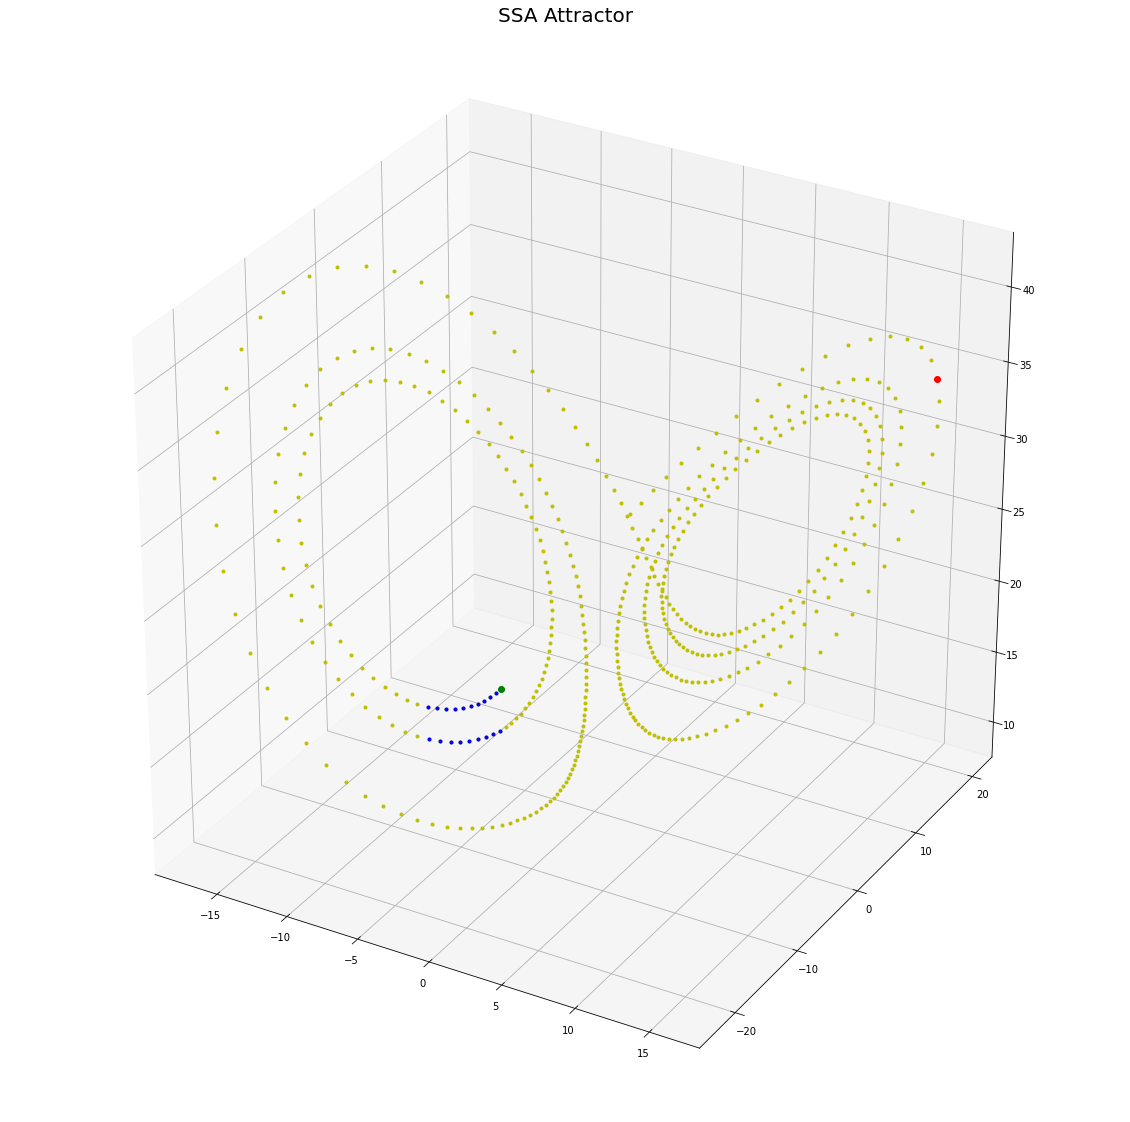

In [ ]:
from sklearn.neighbors import NearestNeighbors
import pandas as pd

# datapoints
extreme = [-16.80, -13.39,  41.55]
data = []
averages = []
visited = []
start = 3500
end = 4000
states_window = states[start:end]
print(len(states_window))
# nearest neighbors model
nn_model = NearestNeighbors(n_neighbors=3, radius=1,algorithm='auto',p=2)

nn_states = []

#for i in range(len(states)):
#    nn_states.append(np.append(states[i]))
    
nn_states = np.asarray(states_window)
nn_model.fit(states_window)
print('\n\n')

# initial state
state = states_window[480] 
print('Start State: ', state)

# init last distance
last_dist = 999

###########################################
# function to select the next neighbor
#
# takes in 
#
#############################################
def select_next(last_dist, distances, indices):
    avg = 0
    next_i = 1
    if (last_dist - distances[0][1]) < .0001:
        next_i = 2
    points = states_window[indices[0]] 
    '''pairs = []
    for x,y in zip(distances[0],points):
        pairs.append((x,y))
        
    points = np.array([x[1] for x in pairs if x[0] > .01 and x[0] < 100])
    avg_x = sum(points[:,0])/len(points)
    avg_y = sum(points[:,1])/len(points)
    avg_z = sum(points[:,2])/len(points)'''
    index = 0
    while distances[0][index] < .3:
      index += 1

    #print(index)

    if abs((distances[0][index] - last_dist)) < 0.001:
      index += 1

    last_dist = distances[0][index]

    if any(all([points[index][i] == l[i] for i in range(len(l))]) for l in visited):
      index += 1

    visited.append(points[index])
    return (states_window[indices[0][next_i]], next_i,points[index])

#########################################
# generate nearest neighbors path
#
#
##########################################
for j in range(0, 1):
    distances, indices = nn_model.kneighbors([state], 5, return_distance=True)
    (xn,yn,zn), next_i, avg = select_next(last_dist, distances, indices) 
    averages.append(avg)
    last_dist = distances[0][next_i]
    s = [avg[0],avg[1],avg[2]]
    data.append(s)
    print(state)
    state = s
    #print(state)

data = np.array(data)
averages = np.array(averages)
#print(averages)

state = states_window[0] 
print('start_state: ', state)
distances, indices = nn_model.kneighbors([state], 20, return_distance=True)
neighbors = states_window[indices][0]

closest_d = 99999
closest_s = []

for n in neighbors:
  dist = np.linalg.norm(np.asarray(extreme) - np.asarray(n))
  if dist < closest_d:
    closest_d = dist
    closest_s = n
print('closest: ', closest_d)
print('closest state: ', closest_s)
next = np.asarray([closest_s])

distances, indices = nn_model.kneighbors([closest_s], 20, return_distance=True)
neighbors = states_window[indices][0]

state = np.array([state])
'''closest_d = 99999
closest_s = []

for n in neighbors:
  dist = np.linalg.norm(np.asarray(extreme) - np.asarray(n))
  if dist < closest_d:
    closest_d = dist
    closest_s = n

print('closest: ', closest_d)
next2 = np.asarray([closest_s])

distances, indices = nn_model.kneighbors([closest_s], 20, return_distance=True)
neighbors = states_window[indices][0]

closest_d = 99999
closest_s = []

for n in neighbors:
  dist = np.linalg.norm(np.asarray(extreme) - np.asarray(n))
  
  if dist < closest_d:
    closest_d = dist
    closest_s = n

print('closest: ', closest_d)
next3 = np.asarray([closest_s])'''

'''for _ in range(1):

  distances, indices = nn_model.kneighbors([closest_s], 20, return_distance=True)
  neighbors = states_window[indices][0]

  closest_d = 99999
  closest_s = []

  for n in neighbors:
    dist = np.linalg.norm(np.asarray(extreme) - np.asarray(n))
    if dist < closest_d:
      closest_d = dist
      closest_s = n

  print('closest: ', closest_d)
  next4 = np.asarray([closest_s])'''


  


fig = plt.figure(figsize=dims)
ax = fig.gca(projection='3d')
ax.plot(states[start:end, 0], states[start:end, 1], states[start:end, 2],'y.')
ax.plot(averages[:, 0], averages[:, 1], averages[:, 2],'ro')
ax.plot(neighbors[:, 0], neighbors[:, 1], neighbors[:, 2],'b.')
#ax.plot(next[:, 0], next[:, 1], next[:, 2],'go')
ax.plot(state[:, 0], state[:, 1], state[:, 2],'go')
#ax.plot(next3[:, 0], next3[:, 1], next3[:, 2],'go')
#ax.plot(next4[:, 0], next4[:, 1], next4[:, 2],'go')
plt.draw()
plt.title('SSA Attractor',fontsize=20)
plt.show()

### Nearest Neighbors Tree
Now that we can generate the nearest neighbors to a given state, we can construct a tree from these neighbors, where each layer of the tree corresponds to one step in the time series. This is the tree that we will be generating dynamically within our "Monte Carlo Tree Seach-esque" implementation. First we write a recursively defined Node structure which we use to construct our tree. Here we'll build an example tree to inspect the structure:

#### Node Definition

In [ ]:
import uuid
class Node:
    
    def __init__(self, s=None, distance=0, parent=None, d=0,n=0):
        self.state = s
        self.children = []
        self.distance = distance
        self.parent = parent
        self.d = d
        self.n = n
        self.w = 0
        self.explore = 0
        self.id = str(uuid.uuid4())

    def get_state(self):
        return self.state
    
    def get_label(self):
        label = '('
        for s in self.state:
            label += str(round(s,2)) + ","
        return label + ') \n d_from_x = ' + str(round(self.d,4)) + '\n n = ' + str(self.n) + ' \n w = ' + str(round(self.w,4))
    
    def get_simple_label(self):
        label = '('
        for s in self.state:
            label += str(round(s,2)) + ","
        return label + ')'

    def is_goal_state(self, state):
        util.raiseNotDefined()

    ############
    # method to get this node's children
    ############
    def get_children(self, model, states, parent=None, num_children=10):
        if len(self.children) == 0:
            distances, indices = model.kneighbors([self.state], num_children, return_distance=True)
            successors = states[indices[0]]
            for state,dist in zip(successors,distances[0]):
                if dist > 0.001:
                    n = Node(s=state,distance=dist)
                    n.set_parent(parent)
                    self.children.append(n)
        
        return self.children
    
    ############
    # method to get this node's children
    ############
    def get_child_states(self):
        states = []
        for child in self.children:
            states.append(child.state)
        return states
    
    ############
    # method to add children to this node
    ############
    def add_children(self, child_states):
        for s in child_states:
            self.children.append(s)

            
    ############
    # method to get number of children
    ############
    def num_children(self):
        return len(self.children)
    
    ############
    # method to print this node and children
    ############
    def __str__(self, level=0):
        ret = "\t"*level+repr(self.state)+ " -> " + str(self.distance) + "\n"
        for child in self.children:
            ret += child.__str__(level+1)
        return ret
    
    def get_metric(self):
        return (1/(self.d*self.n)) + math.sqrt(2) * (math.sqrt((parent.get_n()/self.n)))
    
    def get_state(self):
        return self.state
    
    def get_parent(self):
        return self.parent

    def set_parent(self, parent):
        self.parent = parent
    
    def set_distance(self, dist):
        self.distance = dist
        
    def set_distance(self, d):
        self.d = d
        
    def set_w(self, w):
        self.w = w
        
    def inc_n(self):
        self.n += 1
        
    def get_distance(self):
        return self.distance
    
    def get_d(self):
        return self.d
    
    def get_w(self):
        return self.w
    
    def get_graph(self):
        return self.node
    
    def get_n(self):
        return self.n
    
    def get_id(self):
        return self.id
    
    def __eq__(self, other):
        if isinstance(other, self.__class__):
            return (self.state[0] == other.state[0]) and (self.state[1] == other.state[1]) and (self.state[2] == other.state[2]) 
        else:
            return False

    def __ne__(self, other):
        return not self.__eq__(other)
    
    def __hash__(self):
        return hash(self.state[0] + self.state[1] + self.state[2])
    

#### Example Tree Construction

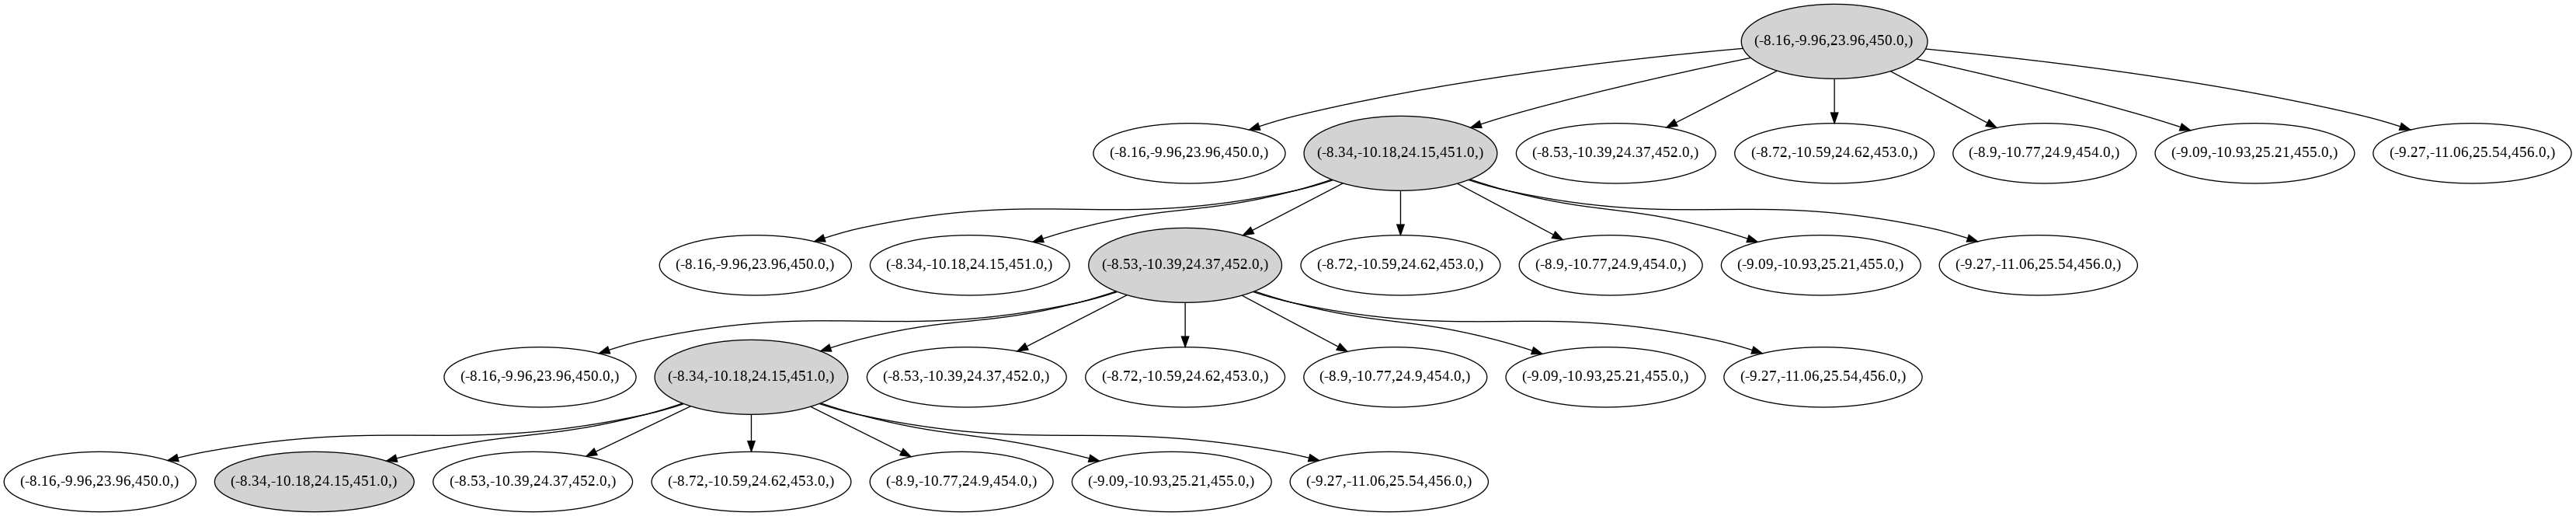

In [ ]:
from sklearn.neighbors import NearestNeighbors
import pandas as pd
import graphviz
import uuid
from IPython.display import Image
dot = graphviz.Digraph(comment='Nearest Neighbors Tree')

# datapoints
data = []
averages = []

# nearest neighbors model
nn = NearestNeighbors(n_neighbors=5, radius=1,algorithm='auto',p=2)

nn_states = []

for i in range(len(states)):
    nn_states.append(np.append(states[i],i))
    
nn_states = np.asarray(nn_states)
nn.fit(nn_states[450:2650])

# initial state
state = np.asarray([-8.16053356,-9.95661924,23.95900615,450 ])

# create a node out of this initial state
current_node = root = Node(s=state,distance=0)

# init last distance
last_dist = 999

# function to select the next neighbor
def select_next(last_dist, distances, indices):
    avg = 0
    next_i = 1
    if (last_dist - distances[0][1]) < .0001:
        next_i = 2
    
    points = nn_states[450:2650][indices[0]] 
    pairs = []
    for x,y in zip(distances[0],points):
        pairs.append((x,y))
        
    points = np.array([x[1] for x in pairs if x[0] > .01 and x[0] < 100])
    avg_x = sum(points[:,0])/len(points)
    avg_y = sum(points[:,1])/len(points)
    avg_z = sum(points[:,2])/len(points)
    
    return (nn_states[450:2650][indices[0][next_i]], next_i,[avg_x,avg_y,avg_z])

existing_nodes = set()

# generate tree
for j in range(450,454):
    
    current_n = dot.node(current_node.get_id(), current_node.get_simple_label(),height='1.0',style='filled')
    distances, indices = nn.kneighbors([state], 7, return_distance=True)
    
    (xn,yn,zn,tn), next_i, avg = select_next(last_dist, distances, indices) 
    averages.append(avg)
    last_dist = distances[0][next_i]
    children = []
    for i in range(len(indices[0])):
        this_state = nn_states[i]
        node = Node(nn_states[450:2650][i],distances[0][i])
        
        if i == next_i:
            successor = node
            this_n = dot.node(node.get_id(), node.get_simple_label(),height='.8',style='filled')
            children.append(successor)
        else:
            this_n = dot.node(node.get_id(), node.get_simple_label(),height='.8')
            children.append(node)
        dot.edge(current_node.get_id(), str(node.get_id()), constraint='true')

    current_node.add_children(children)
    s = [avg[0],avg[1],avg[2], j]
    data.append(s)
    state = s
    current_node = successor

data = np.array(data)
averages = np.array(averages)
tree_filename = 'tree-' + str(uuid.uuid4()) + '.dot'
out = dot.render(format='png', filename=tree_filename)
Image(tree_filename + '.png', width = 1600, height = 900)

Above we have a 6 layer tree, representing possible trajectories of the system over timesteps $t = 0, 1, 2, 3, 4, 5$ going from top to bottom. The $(x,y,z)$ coordinates defining each state are printed as the label for each node in the tree. Now that we have the necessary models trained, and the necessary data structures defined, we can put everything together and implement our MCTS for prediction.

## Monte Carlo Tree Search for Prediction

### Monte Carlo Tree Search
Traditional Monte Carlo Tree Search (MCTS) is an algorithm designed for use in adversarial search, usually within the context of making discrete decisions, in search of an optimal strategy relative to some desired outcome. The method is to begin with some initial state, $s_0$, and at each iteration of the algorithm, a node is selected for expansion. There are many heuristics defined to select which node to expand next, but the idea is to expand nodes which appear to lead to more promising outcomes. The selected node is then "expanded" - that is one or more children, representing successor state(s) to the one being expanded are added to the tree. One of the new nodes is the selected for simulation. The simulation aims to determine the outcome of the entire game or system, if played out from the node we're simulating. This simulation can be random - selecting random successor states until some end is reached, it can follow some defined heuristic, or (as we will be implementing), a model can be applied to the node which predicts the outcome from that state. The simulated outcome from that state is then backpropagated back up all the way to the root - updating each node in the path along the way with the outcome. Typically each node holds a ratio of positive outcomes to total number of times the node has been visited - giving an estimate of the probability that node will lead to a positive outcome. 

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/21/MCTS-steps.svg/1920px-MCTS-steps.svg.png" />

[https://upload.wikimedia.org/wikipedia/commons/thumb/2/21/MCTS-steps.svg/1920px-MCTS-steps.svg.png]

### MCTS Adaptation
Our implementation of MCTS will follow the structure of the traditional approach to the extent that we can. We will expand nodes by adding the nearest neighbors to that state. We will simulate using our trained RNN model, and backpropagate a measure of how "extreme" the model predicts the outcome to be. Then the selection of a new node to expand will be based on how "extreme" portions of the tree are.

What value to backpropagate, and the criteria used to select which nodes to explore are critical to the usefulness and efficiency of this architecture. These components are the main points of continuing forward with this research. For the purposes of testing our approach on the Lorenz Attractor, we select an arbitrary region of the space we know the trajectory to pass through and label it as "extreme". We will then backpropagate the distance of the simulated outcome to this region as our selection measure.

As for selection, MCTS aims to balance "exploration" and "exploitation" - exploration so we thoroughly explore the state space, and exploitation so that we weight our search towards promising parts of the tree. A typical approach is to select the node with the highest *Upper Confidence Bound 1 Applied to Trees* (UCT1) which is defined as:

\begin{align}
UCT1 &= \frac{w_i}{n_i} + c \sqrt{\frac{\ln N_i}{n_i}}
\end{align}

Where:
- $w_i$ stands for the number of positive outcomes for the node considered after the i-th simulation
- $n_i$ stands for the number of simulations for the node considered after the i-th simulation
- $N_i$ stands for the total number of simulations after the i-th move run by the parent node of the one considered
- $c$ is the exploration parameter—theoretically equal to $\sqrt{2}$

As a concrete example, the UCT1 of the above node (under the "Selection" title) with values $w_i = 3$ and $n_i = 3$ works out to:
\begin{align}
UCT1_1 &= \frac{3}{3} + \sqrt 2 \sqrt{\frac{\ln 6}{3}} \\
&= \sqrt{\frac{\ln 36}{3}} + 1
\end{align}
and for it's sibling node:
\begin{align}
UCT1_2 &= \frac{2}{3} + \sqrt 2 \sqrt{\frac{\ln 6}{3}} \\
&= \sqrt{\frac{\ln 36}{3}} + \frac{2}{3}
\end{align}
This won't work in our case, as we don't have a discrete "positive" outcome, but rather a continuous distance to an interesting state; though we can still borrow the structure of this equation in our own solution. The $\frac{w_i}{n_i}$ term contributes the "exploitation" portion, and the $c \sqrt{\frac{\ln N_i}{n_i}}$ term contributes the "exploration" part. We can keep the exploration component as is, and merely ammend the exploitation piece to fit our needs. An initial attempt will be to assign the inverse of the distance to $w_i$, which would result in a greater exploitation score for states that lead closer to extreme states. If this heuristic doesn't fit well, we can adjust it through empirical analysis. This gives us (at least to start) a selection criteria as:

\begin{align}
max \left( \frac{1}{d_i n_i} + c \sqrt{\frac{\ln N_i}{n_i}} \right)
\end{align}

Where $d_i = $ simulated distance after the i-th simulation. We will store this value at each node, and update it as we construct the tree and perform simulations. The last piece to consider for selection is the fact that we add $k$ children for each expansion, and we must either select one for simulation, or simulate them all. Because $k$ will be small (at least in this particular implementation) we will elect to simulate them all. 

### Modified Monte Carlo Tree Search Pseudocode

    Procedure Modified_MCTS(state):
      state.visits++
      if all children of state expanded:
        next_state = UCB(state)
        dist = Modified_MCTS(next_state)
      else:
        if some children of state expanded:
          next_state = expand(random unexpanded child)
        else:
          next_state = state
        dist = RNN_Forecast(next_state)
      update_value(state, dist)

In [ ]:
import math
import numpy as np

def uct(wi,ni,Ni,c):
  exploit = wi/ni
  explore = c*math.sqrt((math.log(Ni)/ni))
  return exploit + explore

vals = [[7,10,21],[2,4,10],[1,6,10],[2,3,6],[3,3,6],[0,3,21],[3,8,21],[1,2,8],[2,3,8],[2,3,8]] 
ucts = []
c = 3
for v in vals:
  ucts.append(uct(v[0],v[1],v[2],c))

print(np.argmax(ucts))
i = 0
for v in ucts:
  print(i, ": ",vals[i], " -> ", v)
  i += 1


# A simple implementation of Priority Queue 
# using Queue. 
class PriorityQueue(object): 
    def __init__(self): 
        self.queue = [] 
  
    def __str__(self): 
        return ' '.join([str(i) for i in self.queue]) 
  
    # for checking if the queue is empty 
    def isEmpty(self): 
        return len(self.queue) == 0
  
    # for inserting an element in the queue 
    def insert(self, data): 
        self.queue.append(data) 
  
    # for popping an element based on Priority 
    def pop(self): 
        try: 
            max = 0
            for i in range(len(self.queue)): 
                if self.queue[i].get_w() > self.queue[max].get_w(): 
                    max = i 
            item = self.queue[max] 
            del self.queue[max] 
            return item 
        except IndexError: 
            print() 
            exit() 
  
'''if __name__ == '__main__': 
    myQueue = PriorityQueue() 
    myQueue.insert(12) 
    myQueue.insert(1) 
    myQueue.insert(14) 
    myQueue.insert(7) 
    print(myQueue)             
    while not myQueue.isEmpty(): 
        print(myQueue.pop())  '''

print('DONE')


7
0 :  [7, 10, 21]  ->  2.3553157384472243
1 :  [2, 4, 10]  ->  2.7761406940777196
2 :  [1, 6, 10]  ->  2.0251277610915857
3 :  [2, 3, 6]  ->  2.985131332708434
4 :  [3, 3, 6]  ->  3.3184646660417676
5 :  [0, 3, 21]  ->  3.022179232469555
6 :  [3, 8, 21]  ->  2.225699257696628
7 :  [1, 2, 8]  ->  3.5590009705064265
8 :  [2, 3, 8]  ->  3.1643305001397595
9 :  [2, 3, 8]  ->  3.1643305001397595
DONE


# Monte Carlo Tree Search Implementation

In [ ]:
dot = graphviz.Digraph(comment='MCTS Tree')

# nearest neighbors model
nn = NearestNeighbors(n_neighbors=5, radius=1,algorithm='auto',p=2)
nn_states = states[3500:4000]
red = 0xFF000

def get_color(d):
  if d > 25:
    return 1
  elif d > 22:
    return 2
  elif d > 19:
    return 3
  elif d > 16:
    return 4
  elif d > 13:
    return 5
  elif d > 10:
    return 6
  elif d > 7:
    return 7
  elif d > 4:
    return 8
  else:
    return 9
###############################
#
# fit nearest neighbors model
#
################################
nn.fit(nn_states)

####################################################
#
# Initialize the root state 
#
####################################################
state = nn_states[0]
print(state)

#######################################################
#
# Initialize the "extreme" state we're searching for
# and get the distance from root state
#
#######################################################
# right wing extreme
extreme = [15.5707533,  18.87584448, 33.28368114]


# left wing extreme
#extreme = [-16.80, -13.39,  41.55]


print('extreme: ', extreme)
print('s: ', nn_states[196])


# get distance from root to extreme
dist = np.linalg.norm(np.asarray(extreme) - np.asarray(state[:3]))

# create a node out of this initial state
current_node = root = Node(s=state,distance=0, d=dist, parent=None)

# create a dot node so we can print the tree
current_n = dot.node(
    current_node.get_id(),
    current_node.get_label(),
    style='filled',
    colorscheme='rdpu9',
    color=str(get_color(current_node.get_d())))

visited = []
frontier = []
iteration = 0

##############################################################################
##############################################################################
#
# Perform MCTS
#
# this will run until we find an extreme state
#
##############################################################################
##############################################################################

#
# While we haven't arrived at an extreme state
#
while (current_node.get_d() != 0) and (current_node.get_d() > 1):

    # increment iteration counter
    iteration += 1
    print('iteration: ', iteration)

    # initialize arrays for the children
    children = []

    ###########################################################################
    #
    # 1) EXPAND
    # get the nearest neighbors to current node
    #
    ###########################################################################
    curr_state = current_node.get_state()
    distances, indices = nn_model.kneighbors(
        [curr_state], 13, return_distance=True)
    
    # create node for viz
    dot.node(
        current_node.get_id(), 
        current_node.get_label(),
        style='filled',
        colorscheme='rdpu9',
        color=str(get_color(current_node.get_d())))

    #
    # get the actual children states from indices returned by nn_model
    #
    ns = states_window[indices][0]

    # iterate over the children
    i = 0
    for tn in ns:
        
        # this child state
        this_state = tn

        #######################################################################
        #
        # 2) SIMULATION
        #
        # run this state through the RNN to predict where it will lead
        #
        #######################################################################
        #yhat = model.predict([[this_state.tolist()]])
        yhat = this_state

        #
        # get the distance from simulation result to extreme state
        #
        dist = np.linalg.norm(np.asarray(extreme) - np.asarray(yhat))

        #
        # get the distance from parent node 
        # (so we don't include parent as it's own child)
        #
        dist_from_parent = np.linalg.norm(
            np.asarray(curr_state[:3]) - np.asarray(this_state))
        
        #
        # as long as this child state isn't the current state 
        #
        if dist_from_parent >.01:

            # create the child node in the NN-tree
            child_node = Node(
                this_state,
                distances[0][i],
                parent=current_node,
                d=dist,n=1)

            # append this node to the child array
            children.append(child_node)

        i += 1

    # add the children to the parent in the NN-tree
    current_node.add_children(children)

    # increment visit count on current node
    current_node.inc_n()

    # update current viz node
    dot.node(
        current_node.get_id(),
        current_node.get_label(),
        style='filled',
        colorscheme='rdpu9',
        color=str(get_color(current_node.get_d())))

    ###########################################################################
    #
    # 3) BACKPROPAGATE
    #
    # backprop count and simulation result up path to root
    #
    ###########################################################################
    prop_up = current_node
    while prop_up.get_parent() != None:

        # get the parent
        parent = prop_up.get_parent()

        # increment parent visit count
        parent.inc_n()

        # add w score of current node to parent's w score
        new_w = parent.get_w() + current_max[0]
        parent.set_w(new_w)

        # update visualization node
        dot.node(
            parent.get_id(),
            parent.get_label(),
            style='filled',
            colorscheme='rdpu9',
            color=str(get_color(parent.get_d())))

        # get this node's parent
        prop_up = prop_up.get_parent()

    ###########################################################################
    #
    # 4) SELECTION
    #
    # select the next node in the tree to expand
    #
    ###########################################################################
    
    #
    # iterate over the children and calculate UCT
    #
    for n in children:
        
        #
        # get the exploit score
        #
        exploit = n.get_d() #999/(n.get_d()*(n.get_n()))
        N = current_node.get_n()
        
        #
        # get the explore score
        #
        explore = math.sqrt(((math.log(N)) * n.get_n())) 

        #
        # get total UCT
        #
        m = exploit + explore
        
        # set the score in the node in the NN-tree
        n.set_w(m)
        
        # update the dot node
        dot.node(
            n.get_id(),
            n.get_label(),
            style='filled',
            colorscheme='rdpu9',
            color=str(get_color(n.get_d())))
        
        # create an edge between this node and its parent
        dot.edge(current_node.get_id(), n.get_id(), constraint='true')

        # append this node to the frontier
        frontier.append(n)    
            
    ##########################################
    #
    # the next node we explore is the max UCT
    #
    ###########################################

    #
    # sort the frontier by UCT
    # (should be a priority queue)
    #
    frontier.sort(key=lambda x: x.get_w(), reverse=False)

    #
    # pop the highest UCT score
    #
    current_node = frontier.pop(0)

    #
    # check to make sure we haven't visited this state before
    # while we have - get the next priority item from frontier
    #
    while any(
        all([current_node.get_state()[i] == l[i] for i in range(len(l))])
         for l in visited):
      current_node = frontier.pop()

    #
    # once we have our next state to explore, add it to visited list
    #
    visited.append(current_node.get_state().tolist())

    # update node for viz
    dot.node(
        current_node.get_id(),
        current_node.get_label(),
        style='filled',
        colorscheme='rdpu9',
        color=str(get_color(current_node.get_d())))
    
tree_filename = 'img/mcts_tree' + '.dot'
out = dot.render(format='png', filename=tree_filename)
Image(tree_filename + '.png', width = 1600, height = 900)

[-3.99602649 -5.78625306 17.26545936]
extreme:  [15.5707533, 18.87584448, 33.28368114]
s:  [-16.80556126 -13.39870968  41.55042617]
iteration:  1
iteration:  2


NameError: ignored

In [ ]:
## create a node out of this initial state
current_node = root = Node(s=state,distance=0, d=dist, parent=None)

extreme = [-0.28234782, -0.26501447, 0.65277364]

distances, indices = nn.kneighbors([current_node.get_state()], 1, return_distance=True)

# iterate over the children's indices
for i in range(len(indices[0])):
    
    # get the actual child state
    this_state = states[i]
    #print(this_state)


# main function for the Monte Carlo Tree Search 
def monte_carlo_tree_search(root): 
      
    for i in range(10): 
        leaf = traverse(root)
        print(root.get_parent())
        root = leaf  
        simulation_result = rollout(leaf) 
        
        print(simulation_result)
        #backpropagate(leaf, simulation_result) 
          
    #return best_child(root)
    #pass 
  
# function for node traversal 
def traverse(node): 
    '''while fully_expanded(node): 
        node = best_uct(node) 
          
    # in case no children are present / node is terminal  
    return pick_univisted(node.children) or node'''
    child = node.get_children(nn, states, node, 2)[0]
    if child.get_distance() < .01:
      child = node.get_children(nn, states, node,  2)[1]
    return child
  
# function for the result of the simulation 
def rollout(node): 
    '''while non_terminal(node): 
        node = rollout_policy(node) 
    return result(node)'''
    s = node.get_state().tolist()
    yhat = model.predict([[s]])[0]
    dist = np.linalg.norm(yhat-extreme)
    return dist
  
# function for randomly selecting a child node 
def rollout_policy(node): 
    return pick_random(node.children) 
  
# function for backpropagation 
def backpropagate(node, result): 
    '''if is_root(node) return
    node.stats = update_stats(node, result)  
    backpropagate(node.parent)'''
    pass 
  
# function for selecting the best child 
# node with highest number of visits 
def best_child(node): 
    pass
    #pick child with highest number of visits 

monte_carlo_tree_search(root)

In [ ]:
import copy

class Node:
  def __init__(self, m, p, s): # move is from parent to node
    self.move, self.parent, self.children = m, p, []
    self.dist, self.visits, self.state  = 0, 0, s

  def expand_node(self):
    '''if not terminal(state):
      for each non-isomorphic legal move m of state:
        nc = Node(m, self) # new child node
        self.children.append(nc)'''
    print(self.get_state())
    distances, indices = nn.kneighbors([self.get_state()], 5, return_distance=True)
    i = 0 
    while distances[0][i] < 0.1:
      print()
      i += 1

    expanded_state = states[indices][0][0]
    dist = np.linalg.norm(np.asarray(extreme) - np.asarray(self.get_state()))
    self.children.append(Node(None, self, expanded_state))

  def update(self, d):
    self.visits += 1
    self.dist += d

  def is_leaf(self):
    return len(self.children)==0

  def has_parent(self):
    return self.parent is not None

  def get_state(self):
    return self.state

  def get_children(self):
    return self.children

  def get_dist(self):
    return self.dist

  def __str__(self):
    return 'Node: ' + str(self.state) + ' visits: ' + str(self.visits) + ' distance: ' + str(self.dist)

def tree_policy_child(state):
  return state.get_children()[0]

def terminal(state):
  return state.get_dist() < 0.01

def evaluate(state):
  print('evaluating: ', state.get_state())
  s = state.get_state()
  s = np.asarray([s])
  print('s: ', s)
  s = s.reshape((s.shape[0], 1, s.shape[1]))
  yhat = model.predict(s)
  print('yhat: ', yhat[0])
  print('extreme: ', extreme)
  dist = np.linalg.norm(np.asarray(extreme) - np.asarray(yhat[0]))
  print('dist: ', dist)
  return dist

def mcts(state):
  n = copy.deepcopy(state)
  for _ in range(15):
    while not n.is_leaf():    # select leaf
      n = tree_policy_child(n)
    n.expand_node()          # expand
    n = tree_policy_child(n)
    #while not terminal(s):    # simulate
    #s = simulation_policy_child(s)
    result = evaluate(n)
    while n.has_parent():     # propagate
      n.update(result)
      n = n.parent
      print(n)
    print('\n\n')
  print('DONE')

start = [-8.16053356,-9.95661924,23.95900615]
root_node  = Node(None, None, start)
mcts(root_node)